In this directory I use astronomical images to train neural network. In this notebook I start with the simple case of stars versus galaxies. That should be relatively simple, at least with sufficient signal to noise. 

This notebook user stricter criteria to better separate the classes.

In [1]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
#wcs is incompabible with newest numpy thus below not used 
#from astropy import wcs
#to access astronomical images in fits format
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression


Now loading the data on the classification and other properties of the objects to be classified. 

In [6]:
df=pd.read_csv('Stripe82_1b.csv',sep=',')
print(df.columns)

Index(['objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'probPSF_u', 'probPSF_g', 'probPSF_r', 'probPSF_i',
       'probPSF_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'run', 'rerun',
       'camcol', 'field', 'type', 'specobjid', 'class', 'subclass', 'redshift',
       'zErr', 'zWarning', 'zErr_noqso', 'zWarning_noqso', 'z_noqso',
       'snMedian_r', 'snMedian_i', 'z_person', 'class_person', 'plate', 'mjd',
       'fiberid'],
      dtype='object')


Now looking on the classes, the targets and their counts. 

In [7]:
print(df['class'].value_counts())

GALAXY    3205
STAR      1735
QSO        355
Name: class, dtype: int64


Now I load an image and to do a first test display of the numeric data.

In [9]:
path='/home/tobias/ml-testing/astr-images/'
hbin=fits.open(path+'f2001_rdeep.fits.gz')
im1=hbin[0].data
#hbin.close()
print(im1)

[[-0.1769429   0.8691173   0.8408659  ... -1.000337   -0.7853276
  -0.45219374]
 [ 0.75963277 -0.4932522   1.3954576  ... -0.41785482 -1.3604484
  -0.5760638 ]
 [ 0.74020797  0.50546163  0.67057353 ...  0.37528276 -0.6279215
  -0.12317654]
 ...
 [ 0.8284947   0.14578946 -0.6937766  ...  1.4887718   2.2809432
   2.2037222 ]
 [ 0.9416072   0.7137203   0.43595394 ...  1.1946634   2.0303423
   2.3305871 ]
 [ 0.57620764 -0.2957804   0.5933519  ...  0.98817205  1.3469133
   2.5567775 ]]


I now built a function which gets the area mcovers by an image. That is used later to find the right image for the targets.

In [10]:
def image_area(dat):
    ra_ref=dat[0].header['CRVAL1']
    ra_center=dat[0].header['CRPIX1']
    ra_scale=dat[0].header['CD1_1']
    dec_ref=dat[0].header['CRVAL2']
    dec_center=dat[0].header['CRPIX2']
    dec_scale=dat[0].header['CD2_2'] 
    image=dat[0].data
    res=np.array([[ra_ref+(1-ra_center)*ra_scale,ra_ref+(image.shape[0]-ra_center)*ra_scale],[dec_ref+(1-dec_center)*dec_scale,dec_ref+(image.shape[1]-dec_center)*dec_scale]])
    return res

Similiarly the function image_par gets the coordinate parameter of an image for this data set.

In [11]:
#assumes that the image pixel coordiantes are perfectly aligned with the skyb coordiates ra and dec
#that is true for this data set but in general another two parameters are needed to specify the miss alignment
def image_par(dat):
    ra_ref=dat[0].header['CRVAL1']
    ra_center=dat[0].header['CRPIX1']
    ra_scale=dat[0].header['CD1_1']
    dec_ref=dat[0].header['CRVAL2']
    dec_center=dat[0].header['CRPIX2']
    dec_scale=dat[0].header['CD2_2'] 
    par=np.array([ra_ref,ra_center,ra_scale,dec_ref,dec_center,dec_scale])
    return par

Below I test the image area function.

In [12]:
res=image_area(hbin)
print(res)

[[50.00036 49.49964]
 [-1.25036 -0.74964]]


Below I build a function which gets the image position of an object whose sky position is known. 
The information on the image can be either obtained from an image or from the opreviously collected image coordinate parameters.

In [13]:
#ra dec position coordinate of object, dat is image inpt, not zero if image==True,
# par is parameter inpu not yero if image==False
def image_xy(ra,dec,dat=0,par=0,image=True):
    #image is used input and the parameters are used
    if image==True:
        ra_ref=dat[0].header['CRVAL1']
        ra_center=dat[0].header['CRPIX1']
        ra_scale=dat[0].header['CD1_1']
        dec_ref=dat[0].header['CRVAL2']
        dec_center=dat[0].header['CRPIX2']
        dec_scale=dat[0].header['CD2_2'] 
    #paramter input    
    else:   
        ra_ref=par[0]
        ra_center=par[1]
        ra_scale=par[2]
        dec_ref=par[3]
        dec_center=par[4]
        dec_scale=par[5]
    #get the positions (pixels on image) 
    # the cosine part is only important if the image not close to the euqator 
    x=ra_center+(ra-ra_ref)/ra_scale*np.cos(dec/180*np.pi)
    y=dec_center+(dec-dec_ref)/dec_scale
    pixels=np.array([x,y])
    return pixels

Test use on image.

In [14]:
pixels=image_xy(49.8,-1,dat=hbin,image=True)
print(f"pixels are {pixels}")

pixels are [1822.52377493 2277.        ]


Now getting all images in a list. 

In [15]:
list_input_files=[f for f in os.listdir(path) 
    if f.endswith('_rdeep.fits.gz') and os.path.isfile(os.path.join(path, f))]
list_input_files.sort()
print(list_input_files)

['f2001_rdeep.fits.gz', 'f2002_rdeep.fits.gz', 'f2003_rdeep.fits.gz', 'f2004_rdeep.fits.gz', 'f2005_rdeep.fits.gz', 'f2011_rdeep.fits.gz', 'f2012_rdeep.fits.gz', 'f2013_rdeep.fits.gz', 'f2014_rdeep.fits.gz', 'f2015_rdeep.fits.gz', 'f2021_rdeep.fits.gz', 'f2022_rdeep.fits.gz', 'f2023_rdeep.fits.gz', 'f2024_rdeep.fits.gz', 'f2025_rdeep.fits.gz', 'f2031_rdeep.fits.gz', 'f2032_rdeep.fits.gz', 'f2033_rdeep.fits.gz', 'f2034_rdeep.fits.gz', 'f2035_rdeep.fits.gz', 'f2041_rdeep.fits.gz', 'f2042_rdeep.fits.gz', 'f2043_rdeep.fits.gz', 'f2044_rdeep.fits.gz', 'f2045_rdeep.fits.gz', 'f2051_rdeep.fits.gz', 'f2052_rdeep.fits.gz', 'f2053_rdeep.fits.gz', 'f2054_rdeep.fits.gz', 'f2055_rdeep.fits.gz', 'f2061_rdeep.fits.gz', 'f2062_rdeep.fits.gz', 'f2063_rdeep.fits.gz', 'f2064_rdeep.fits.gz', 'f2065_rdeep.fits.gz']


Now I get the centers and image parameters for all images.

In [16]:
centers=np.zeros((2,len(list_input_files)))
wcs_par=np.zeros((6,len(list_input_files)))
for i in range(len(list_input_files)):
    print(i)
    #get images
    hbin=fits.open(path+list_input_files[i],memmap=True)
    #get parameters wanted 
    res=image_area(hbin)
    par=image_par(hbin)
    hbin.close()
    centers[0,i]=(res[0,0]+res[0,1])/2  #center is avarage of extension in both dimensions
    centers[1,i]=(res[1,0]+res[1,1])/2
    #parameters to find objects on images
    wcs_par[:,i]=par
print(centers)    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
[[ 4.97500000e+01  4.97500000e+01  4.97500000e+01  4.97500000e+01
   4.97500000e+01  5.02500000e+01  5.02500000e+01  5.02500000e+01
   5.02500000e+01  5.02500000e+01  5.07500000e+01  5.07500000e+01
   5.07500000e+01  5.07500000e+01  5.07500000e+01  5.12500000e+01
   5.12500000e+01  5.12500000e+01  5.12500000e+01  5.12500000e+01
   5.17500000e+01  5.17500000e+01  5.17500000e+01  5.17500000e+01
   5.17500000e+01  5.22500000e+01  5.22500000e+01  5.22500000e+01
   5.22500000e+01  5.22500000e+01  5.27500000e+01  5.27500000e+01
   5.27500000e+01  5.27500000e+01  5.27500000e+01]
 [-1.00000000e+00 -5.00000000e-01 -1.08246745e-15  5.00000000e-01
   1.00000000e+00 -1.00000000e+00 -5.00000000e-01 -1.08246745e-15
   5.00000000e-01  1.00000000e+00 -1.00000000e+00 -5.00000000e-01
  -1.08246745e-15  5.00000000e-01  1.00000000e+00 -1.00000000e+00
  -5.00000000e-01 -1.08246745e-15  5.00000000e-01  1.00000000e

Now I am getting closest image and the pixels positions on them for all objects of the data frame. Further I create a binary classifier based on whether a galaxy or not to start with a  simple binary classification case. 

Here I am concervative, I exclude QSO which are mostly star like but not to 100%. I also require in addition that the shape classifiocation (star like or not) agrees with the spectral classifier.

In [33]:
df['galaxy'] = np.where(df['class']== 'GALAXY', True, False)
#Also I add dummy columns which are later filter with the image and the pixels positions on it for all onbjects
df['image']=-1
df['pixel_x']=-1.0
df['pixel_y']=-1.0
print(df.galaxy.value_counts())
#mark bad ones, exclude qso
df['bad'] = False
for i in range(df.shape[0]):
    if df['class'].iat[i]=='QSO':
        df.bad.iat[i]=True
    elif  df['class'].iat[i]=='GALAXY' and (df.probPSF_g.iat[i]==1 or df.probPSF_r.iat[i]==1 or df.probPSF_i.iat[i]==1):
        df.bad.iat[i]=True
    elif  df['class'].iat[i]=='STAR' and (df.probPSF_g.iat[i]==0 or df.probPSF_r.iat[i]==0 or df.probPSF_i.iat[i]==0):
        df.bad.iat[i]=True        
print(df.bad.value_counts())

True     3205
False    2090
Name: galaxy, dtype: int64
False    4722
True      573
Name: bad, dtype: int64


Printing the head to check whether adding the columns worked. 

In [34]:
print(df.head())

                 objid         ra       dec  psfMag_u  psfMag_g  psfMag_r  \
0  1237645943976493294  50.792975  0.927009  21.84817  20.46660  19.60007   
1  1237645943976493295  50.794224  0.904795  20.94097  20.49901  19.96817   
2  1237645943976493332  50.906646  1.021555  24.03358  21.89073  20.53197   
3  1237645943976493336  50.769166  0.913952  22.15892  21.43051  20.75715   
4  1237645943976493356  50.786341  0.994653  20.89643  20.28635  20.01297   

   psfMag_i  psfMag_z  probPSF_u  probPSF_g  ...  z_person  class_person  \
0  19.05548  18.68311          0          0  ...         0             0   
1  20.00629  19.91921          1          1  ...         0             0   
2  19.10751  18.44994          1          0  ...         0             0   
3  20.45952  20.03378          0          0  ...         0             0   
4  19.57017  19.41821          1          1  ...         0             0   

   plate    mjd  fiberid  galaxy  image  pixel_x  pixel_y    bad  
0    712  521

Below I go over all objects, find the closest image and get then the pixel position of the object.. 

In [35]:
for i in range(df.shape[0]):
    #distances to all images ceneters
    r=np.sqrt((df['ra'][i]-centers[0])**2+(df['dec'][i]-centers[1])**2)
    #id of the image
    df['image'].iloc[i]=np.argmin(r)
    #get pixel coordinates of image 
    coor=image_xy(df['ra'][i],df['dec'][i],par=wcs_par[:,df['image'].iloc[i]],image=False)
    df['pixel_x'].iloc[i]=coor[0]
    df['pixel_y'].iloc[i]=coor[1]
    

/tmp/ipykernel_14890/3953301984.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'].iloc[i]=np.argmin(r)
/tmp/ipykernel_14890/3953301984.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixel_x'].iloc[i]=coor[0]
/tmp/ipykernel_14890/3953301984.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixel_y'].iloc[i]=coor[1]


Checking whether the columns are now filled with right coordinates. 

In [36]:
print(df.head())

                 objid         ra       dec  psfMag_u  psfMag_g  psfMag_r  \
0  1237645943976493294  50.792975  0.927009  21.84817  20.46660  19.60007   
1  1237645943976493295  50.794224  0.904795  20.94097  20.49901  19.96817   
2  1237645943976493332  50.906646  1.021555  24.03358  21.89073  20.53197   
3  1237645943976493336  50.769166  0.913952  22.15892  21.43051  20.75715   
4  1237645943976493356  50.786341  0.994653  20.89643  20.28635  20.01297   

   psfMag_i  psfMag_z  probPSF_u  probPSF_g  ...  z_person  class_person  \
0  19.05548  18.68311          0          0  ...         0             0   
1  20.00629  19.91921          1          1  ...         0             0   
2  19.10751  18.44994          1          0  ...         0             0   
3  20.45952  20.03378          0          0  ...         0             0   
4  19.57017  19.41821          1          1  ...         0             0   

   plate    mjd  fiberid  galaxy  image      pixel_x      pixel_y    bad  
0    

Analyse the new columns content. 

In [37]:
#sorted by value to see which iamges are used
print(df.image.value_counts().sort_index(0))
print(df.pixel_x.describe())
print(df.pixel_y.describe())

5     227
6     181
7     231
8     244
9     190
10    154
11    192
12    245
13    257
14    227
15    149
16    167
17    203
18    153
19    168
20    173
21    238
22    199
23    199
24    195
25    247
26    277
27    279
28    261
29    239
Name: image, dtype: int64
count    5295.000000
mean     2297.375179
std      1304.735601
min         4.991131
25%      1179.141102
50%      2323.782704
75%      3418.760954
max      4549.603869
Name: pixel_x, dtype: float64
count    5295.000000
mean     2253.338893
std      1304.361251
min       -70.538413
25%      1145.468620
50%      2213.411517
75%      3379.435823
max      4637.182527
Name: pixel_y, dtype: float64


/tmp/ipykernel_14890/1114175374.py:2: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  print(df.image.value_counts().sort_index(0))


I now sort the row of the data frame by image, that minizie how often the images need to be loaded. 

In [38]:
df=df.sort_values(by='image')
#reset index since the previous row is not wanted 
df=df.reset_index()
print(df.head)

<bound method NDFrame.head of       index                objid         ra       dec  psfMag_u  psfMag_g  \
0      3582  1237663237128388950  50.162303 -1.235258  22.56924  20.53544   
1      3630  1237666299481686305  50.002163 -0.867332  24.46523  21.17397   
2      3631  1237666299481751635  50.090055 -1.048266  19.01876  17.18463   
3      3632  1237666299481751800  50.009985 -0.929502  24.62791  20.55204   
4      3633  1237666299481751975  50.071922 -1.027052  21.75187  21.11250   
...     ...                  ...        ...       ...       ...       ...   
5290   4986  1237666302167089616  52.345132  1.118150  23.89564  22.45461   
5291   4985  1237666302167089405  52.259900  1.202159  23.45212  22.66528   
5292   4984  1237666302167089358  52.356925  1.077842  21.11749  20.82195   
5293   1058  1237660241925177639  52.107396  0.967077  22.52552  20.91562   
5294   3259  1237660241925243084  52.188624  0.867991  21.24787  18.69862   

      psfMag_r  psfMag_i  psfMag_z  probPSF_u

Now the arrays with the images are collected. For now I collected 11 times 11 pixels. The n umber is odd because it should usually centered on the brightest image. 

In [39]:
delta=5
#collected array
cut_outs=np.zeros((2*delta+1,2*delta+1,df.shape[0]))
#parameter to indicate whether an image exist. 
df['off_image']=False
for i in range(df.shape[0]):
    #image loaded if first image
    if i==0:
        #load file
        hbin=fits.open(path+list_input_files[df.image.iloc[i]])
        #get image, need to be transposed because of difefrent definitions in astronomy and numpy on what is the first axis
        image=hbin[0].data.T
    else:
        #or if new image
        if df.image.iloc[i]!=df.image.iloc[i-1]:
            hbin=fits.open(path+list_input_files[df.image.iloc[i]])
            #need to be transposed because of difefrent definitions in astronomy and numpy on what is the first axis
            image=hbin[0].data.T  
    #gfigure out if within image borders  then cut out image is collected       
    if round(df.pixel_x.iloc[i])>delta and round(df.pixel_x.iloc[i])<image.shape[0]-delta and  round(df.pixel_y.iloc[i])>delta and round(df.pixel_y.iloc[i])<image.shape[1]-delta:
        cut_outs[:,:,i]=image[round(df.pixel_x.iloc[i])-delta:round(df.pixel_x.iloc[i])+delta+1,round(df.pixel_y.iloc[i])-delta:round(df.pixel_y.iloc[i])+delta+1]
    else:
        #if not marker column set to true
        print(f"row {i} is off the image")
        df['off_image'].iloc[i]=True

row 74 is off the image
row 75 is off the image
row 105 is off the image


/tmp/ipykernel_14890/4177535269.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['off_image'].iloc[i]=True


row 908 is off the image
row 1011 is off the image
row 1046 is off the image
row 1052 is off the image
row 1060 is off the image
row 1347 is off the image
row 1921 is off the image
row 2030 is off the image
row 2245 is off the image
row 2604 is off the image
row 2847 is off the image
row 2894 is off the image
row 2910 is off the image
row 2915 is off the image
row 2923 is off the image
row 3015 is off the image
row 3016 is off the image
row 3114 is off the image
row 3787 is off the image
row 3889 is off the image
row 3918 is off the image
row 3955 is off the image
row 3977 is off the image
row 4022 is off the image
row 4237 is off the image
row 4616 is off the image
row 4940 is off the image
row 5062 is off the image
row 5193 is off the image
row 5250 is off the image
row 5257 is off the image
row 5262 is off the image
row 5271 is off the image


Now I check how rows are off the image.

In [40]:
print(df.off_image.value_counts())

False    5259
True       36
Name: off_image, dtype: int64


Not many, thus they can be ignore. Now  display one object of each kind. 

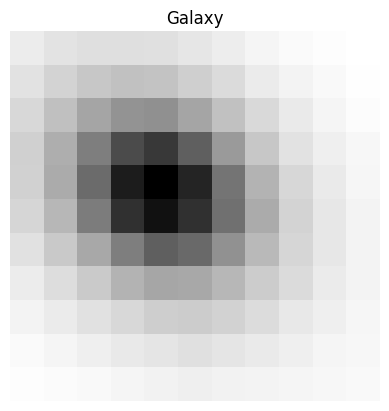

In [41]:
plt.axis('off')
plt.title("Galaxy")
plt.imshow(1-cut_outs[:,:,0].T,cmap=cm.gray, interpolation='nearest')

In [42]:
#finding star and galaxies for display
fs=df['class'][df['class']=='STAR']
print(fs)
fq=df['class'][df['class']=='QSO']
print(fq)

1       STAR
2       STAR
3       STAR
5       STAR
6       STAR
        ... 
5286    STAR
5287    STAR
5288    STAR
5289    STAR
5294    STAR
Name: class, Length: 1735, dtype: object
4       QSO
27      QSO
28      QSO
51      QSO
67      QSO
       ... 
5229    QSO
5240    QSO
5249    QSO
5268    QSO
5292    QSO
Name: class, Length: 355, dtype: object


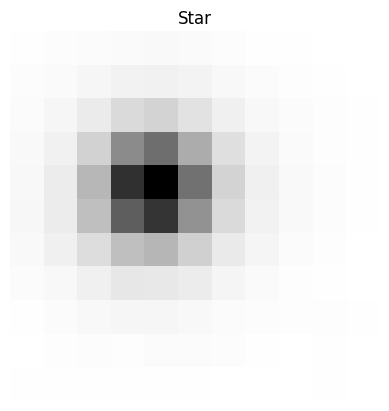

In [43]:
plt.axis('off')
plt.title("Star")
plt.imshow(1-cut_outs[:,:,fs.index[0]].T,cmap=cm.gray, interpolation='nearest')

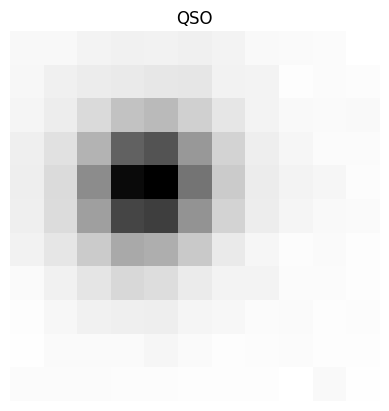

In [44]:
plt.axis('off')
plt.title("QSO")
plt.imshow(1-cut_outs[:,:,fq.index[0]].T,cmap=cm.gray, interpolation='nearest')

As it should be the galaxy is less concentrated than the star and the QSO. It is also visisble that the object are not fully isolated as often the case for images. 

I now drop the objects for which no image could have been found. I also add a forth dimension to the iamge array as needed by pytorch. 
I also exclude now the QSOs and the other objects which have potentailly bad classifications. 

Because of the noise I do not rescale the cut out images, since rescaling makes that noise is level is very different between different images, while it should be rather similar in this data set.    

In [47]:
#new data frame omitting the object where no image could be found  and laso bad ones
df2=df[(df.off_image==False) & (df.bad==False)]
print(df2.shape)
#new image array, to which also a 4 dimension of zero size is added 
cut_outs2=np.zeros((2*delta+1,2*delta+1,1,df2.shape[0]))
counter=0
for i in range(df.shape[0]):
    if df.off_image.iloc[i]==False and df.bad.iloc[i]==False:
        #adding the cut outs not of image
        cut_outs2[:,:,0,counter]=cut_outs[:,:,i]
        counter+=1
#Now I add the iamge value to the data frame, that can be used for all connected percitron networks 
x=0
for i in range(cut_outs2.shape[0]):
    for j in range(cut_outs2.shape[1]):
        df2[x]=cut_outs2[i,j,0,:]
        x+=1

(4691, 49)


/tmp/ipykernel_14890/1160719888.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_14890/1160719888.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_14890/1160719888.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Now the data is mostly prepared besides some libraries specifices. 



First I do basic setup tasks relevant for for all torch networks. For now that these are two, firstly a fully connected multilayer network as perceptron. Secondly, a network which uses twodiemnsionalk convolutional layer whoch should be optimized for images. 

First adding the cpu. 

In [48]:
#adding cpu
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


In [49]:
#need to be transposed to get into torch format of batch, channels, x, y
#splitting, feature_mlp, targets, feature_images, df properties
feature_train,feature_test,target_train, target_test,image_train,image_test,df_train,df_test= train_test_split(df2.loc[:,0:120],df2.loc[:,"galaxy"],cut_outs2.T,df2,train_size=0.70, shuffle=True, random_state=1)
print("shape of image train data")
print(image_train.shape)

shape of image train data
(3283, 1, 11, 11)


Now I change the target data type to numpy array where that is not yet the case. 

In [50]:
 
feature_train, target_train = np.array(feature_train), np.array(target_train)
feature_test, target_test = np.array(feature_test), np.array(target_test)
print(type(target_train),type(image_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Now I create a class which creates the classification data sets as needed for torch. 

In [51]:
class ClassificationDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

Now I create the data sets as needed for both neural network types. 

In [52]:
train_dataset = ClassificationDataset(torch.from_numpy(feature_train).float(), torch.from_numpy(target_train).float())
test_dataset = ClassificationDataset(torch.from_numpy(feature_test).float(), torch.from_numpy(target_test).float())
train_im_dataset = ClassificationDataset(torch.from_numpy(image_train).float(), torch.from_numpy(target_train).float())
test_im_dataset = ClassificationDataset(torch.from_numpy(image_test).float(), torch.from_numpy(target_test).float())
#print type as test 
print(type(torch.from_numpy(image_test).float()))
print(type(test_im_dataset))


<class 'torch.Tensor'>
<class '__main__.ClassificationDataset'>


Now create the class of the perceptron layer. 

In [53]:
#now 3 layers 
#two options only 
class BinaryClassification3(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassification3, self).__init__()
        self.fc1 = nn.Linear(num_features, 60)
        self.fc2 = nn.Linear(60, 20)  
        self.fc3 = nn.Linear(20, 8)        
        self.fc4 = nn.Linear(8, 1)   
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return (x)

Now I define the parameters needed. 

In [54]:
EPOCHS = 200
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_FEATURES = 121
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_pred = DataLoader(dataset=train_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Finally I define the model plus the final parameters. 

In [55]:
model =BinaryClassification3(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#in loss_stats the statistic is collected 
loss_stats = {
    'train': [], 'test': []
}


BinaryClassification3(
  (fc1): Linear(in_features=121, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)


Now I run the fit. 

In [56]:

print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        test_epoch_loss = 0
        
        model.eval()
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
            y_test_pred = model(X_test_batch)
                        
            test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
            test_epoch_loss += test_loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.39650 | Test Loss: 0.15859
Epoch 002: | Train Loss: 0.28457 | Test Loss: 0.21007
Epoch 003: | Train Loss: 0.24558 | Test Loss: 0.19359
Epoch 004: | Train Loss: 0.15003 | Test Loss: 0.18460
Epoch 005: | Train Loss: 0.14339 | Test Loss: 0.20719
Epoch 006: | Train Loss: 0.18516 | Test Loss: 0.27215
Epoch 007: | Train Loss: 0.18671 | Test Loss: 0.19009
Epoch 008: | Train Loss: 0.14542 | Test Loss: 0.19010
Epoch 009: | Train Loss: 0.15374 | Test Loss: 0.18877
Epoch 010: | Train Loss: 0.11495 | Test Loss: 0.26060
Epoch 011: | Train Loss: 0.13878 | Test Loss: 0.18429
Epoch 012: | Train Loss: 0.10581 | Test Loss: 0.17689
Epoch 013: | Train Loss: 0.10710 | Test Loss: 0.17759
Epoch 014: | Train Loss: 0.11684 | Test Loss: 0.24961
Epoch 015: | Train Loss: 0.11618 | Test Loss: 0.17678
Epoch 016: | Train Loss: 0.11140 | Test Loss: 0.27259
Epoch 017: | Train Loss: 0.23126 | Test Loss: 0.19075
Epoch 018: | Train Loss: 0.12521 | Test Loss: 0.16913
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.09715 | Test Loss: 0.30081
Epoch 154: | Train Loss: 0.07029 | Test Loss: 0.23859
Epoch 155: | Train Loss: 0.06412 | Test Loss: 0.23707
Epoch 156: | Train Loss: 0.06258 | Test Loss: 0.24550
Epoch 157: | Train Loss: 0.06217 | Test Loss: 0.24797
Epoch 158: | Train Loss: 0.06231 | Test Loss: 0.31081
Epoch 159: | Train Loss: 0.06222 | Test Loss: 0.30986
Epoch 160: | Train Loss: 0.06814 | Test Loss: 0.23241
Epoch 161: | Train Loss: 0.06231 | Test Loss: 0.24567
Epoch 162: | Train Loss: 0.06195 | Test Loss: 0.24635
Epoch 163: | Train Loss: 0.06219 | Test Loss: 0.25348
Epoch 164: | Train Loss: 0.06249 | Test Loss: 0.23924
Epoch 165: | Train Loss: 0.06269 | Test Loss: 0.24485
Epoch 166: | Train Loss: 0.06232 | Test Loss: 0.31187
Epoch 167: | Train Loss: 0.06183 | Test Loss: 0.25428
Epoch 168: | Train Loss: 0.06203 | Test Loss: 0.31708
Epoch 169: | Train Loss: 0.06169 | Test Loss: 0.32021
Epoch 170: | Train Loss: 0.06136 | Test Loss: 0.32187
Epoch 171: | Train Loss: 0.0

Now I define a function which predicts the values (probablities) for all samples. 

In [57]:
def pred_torch(model,data):
    y_pred_list_c = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in data:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_pred_list_c.append(y_test_pred.cpu().numpy())
    y_pred_list_c = [a.squeeze().tolist() for a in y_pred_list_c]
    return y_pred_list_c  

That is then applied on all data. 

In [58]:
m_test=pred_torch(model,test_loader)
m_train=pred_torch(model,train_loader_pred)

I now plot the loss against the epoch. 

Text(0, 0.5, 'BCE loss')

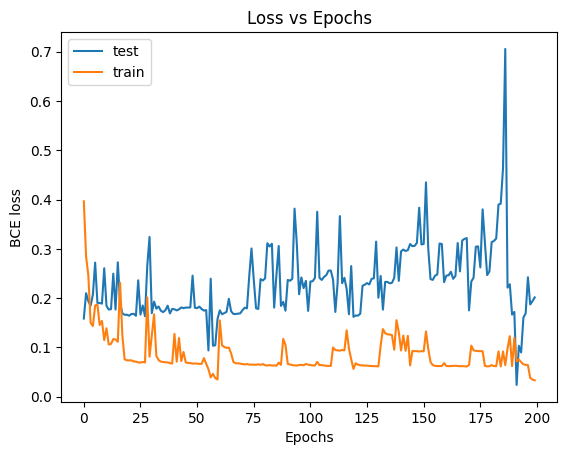

In [59]:

plt.plot(loss_stats['test'],label='test')
plt.plot(loss_stats['train'],label='train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')

There is likely overfitting, at least the loss of test improves less at the end.

Now I am building a first convolutional network. First loading the data again.  

In [60]:
train_im_loader = DataLoader(dataset=train_im_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_im_loader = DataLoader(dataset=test_im_dataset, batch_size=1)
train_im_loader_pred = DataLoader(dataset=train_im_dataset, batch_size=1)

Now I build the network. 

In [62]:
class CNNBinary3(torch.nn.Module):
    #no padding because image does not really end when the data ends. 
    def __init__(self):
        super(CNNBinary3, self).__init__()
        # L1 ImgIn shape=(?, 11, 11, 1)
        # Conv -> (?, 9, 9, 12)
        # Pool -> (?, 4, 4, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 4, 4, 32)
        # Conv      ->(?, 2, 2, 32)
        # Pool      ->(?, 1, 1, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 FC 1x1x32 inputs -> 16 outputs
        self.fc1 = torch.nn.Linear(1 * 1 * 32, 64, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer3 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L4 Final FC 64 inputs -> 1 output
        self.fc2 = torch.nn.Linear(64, 1, bias=True) #
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = torch.sigmoid(self.fc2(out))
        return out

Define the model. 

In [63]:
keep_prob=1
model2 =CNNBinary3()
model2.to(device)
print(model2)

CNNBinary3(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


/tmp/ipykernel_14890/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


In [64]:
#define the function to fit it
#parameters: model used, train_data, test_data, epchs, batch_size, learning_rate, file to collect sats, 
#optional regularization 
def torch_fit(model,train_loader,test_loader,epochs,batch_size,learning_rate,loss_stats,l2reg=0):
    learning_rate = learning_rate
    criterion = torch.nn.BCELoss()    # Softmax is internally computed.
    #if no regularization
    if l2reg==0:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    #l2 regularization is added in optimizer as weight_decay=1e-5 or nsimilar 
    else:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate,weight_decay=l2reg)        
    print("Begin training.")
    for e in tqdm(range(1, epochs+1)):
    
        # TRAINING
        train_epoch_loss = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
        
            y_train_pred = model(X_train_batch)
        
            train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
            train_loss.backward()
            optimizer.step()
        
            train_epoch_loss += train_loss.item()
        
        
        # VALIDATION    
        with torch.no_grad():
        
            test_epoch_loss = 0
        
            model.eval()
            for X_test_batch, y_test_batch in test_loader:
                X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
                y_test_pred = model(X_test_batch)
                        
                test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
                test_epoch_loss += test_loss.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
    
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')    

Now define the array for data collection and then fit the data. 

In [66]:
#something here wrong but only here, regularized below works 
loss_stats_test = {
    'train': [], 'test': []
}
torch_fit(model2,train_im_loader,test_im_loader,200,64,0.001,loss_stats_test)

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 33.99495 | Test Loss: 34.37500
Epoch 002: | Train Loss: 33.91192 | Test Loss: 34.37500
Epoch 003: | Train Loss: 33.95344 | Test Loss: 34.37500
Epoch 004: | Train Loss: 33.97420 | Test Loss: 34.37500
Epoch 005: | Train Loss: 33.93268 | Test Loss: 34.37500
Epoch 006: | Train Loss: 33.99495 | Test Loss: 34.37500
Epoch 007: | Train Loss: 33.91192 | Test Loss: 34.37500
Epoch 008: | Train Loss: 33.95344 | Test Loss: 34.37500
Epoch 009: | Train Loss: 33.97420 | Test Loss: 34.37500
Epoch 010: | Train Loss: 33.91192 | Test Loss: 34.37500
Epoch 011: | Train Loss: 34.01571 | Test Loss: 34.37500


KeyboardInterrupt: 

Below I plot both neural network results. 

(0.0, 3.0)

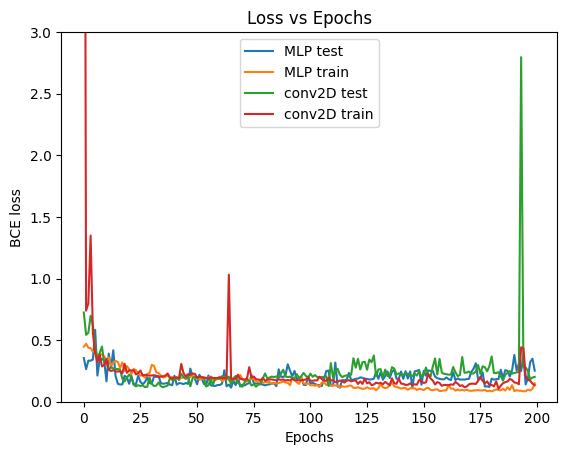

In [47]:
plt.plot(loss_stats['test'],label='MLP test')
plt.plot(loss_stats['train'],label='MLP train')
plt.plot(loss_stats_test['test'],label='conv2D test')
plt.plot(loss_stats_test['train'],label='conv2D train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')
plt.ylim(0,3)

Convolutional looks better, less overfitting, but it also not look perfect and the final loss is not really good. Could be not enough epochs for train. There are wiggles in test seem like that there is overfitting also there. REuslts change every fot slightly. 

Now I do some other algorithms with standard settings. First xgboost. 

In [67]:
xc1=XGBClassifier(max_depth=6).fit(feature_train,target_train)

Now predicting the results and getting the confusing matrixes. 

In [68]:
train_pred=xc1.predict(feature_train)
test_pred=xc1.predict(feature_test)
train_pred_prob=xc1.predict_proba(feature_train)
test_pred_prob=xc1.predict_proba(feature_test)
conf_train = confusion_matrix(target_train, train_pred)
conf_test = confusion_matrix(target_test, test_pred)
print("confusion matrix xgboost train")
print(conf_train)
print("confusion matrix xgboost test")
print(conf_test)

confusion matrix xgboost train
[[1115    0]
 [   0 2168]]
confusion matrix xgboost test
[[478   6]
 [  6 918]]


Looks rather good now, only 6 wrong each. 

Now logistic regression 

In [70]:
#2000 in train 91 56,  test 65 45  not converged warning
#now converged same numbers
lc1=LogisticRegression(max_iter=3000,penalty='none').fit(feature_train,target_train)

In [71]:
l_train_pred=lc1.predict(feature_train)
l_test_pred=lc1.predict(feature_test)
l_train_pred_prob=lc1.predict_proba(feature_train)
l_test_pred_prob=lc1.predict_proba(feature_test)
l_conf_train = confusion_matrix(target_train, l_train_pred)
l_conf_test = confusion_matrix(target_test, l_test_pred)
print("confusion matrix logistic regression train")
print(l_conf_train)
print("confusion matrix logistic regression test")
print(l_conf_test)

confusion matrix logistic regression train
[[1115    0]
 [   0 2168]]
confusion matrix logistic regression test
[[475   9]
 [  8 916]]


Also not so bad, but a little worse.

Now prediction for neural network. 

In [72]:
c_test=pred_torch(model2,test_im_loader)
c_train=pred_torch(model2,train_im_loader_pred)

Define function to get confusion matrix. 

In [73]:
def conf_for_torch(predict,target):
    #round prediction
    round_pred=np.round(np.array(predict))
    conf_matrix = confusion_matrix(target, round_pred)
    return conf_matrix

In [74]:
conf_test_m=conf_for_torch(m_test,target_test)
conf_train_m=conf_for_torch(m_train,target_train)
print("3 layer perceptron")
print("train")
print(conf_train_m)
print("test")
print(conf_test_m)

3 layer perceptron
train
[[1113    2]
 [   2 2166]]
test
[[479   5]
 [  7 917]]


Percitron seems about as good as xgboost. 

Now convolutional network. 

In [75]:
conf_test_c=conf_for_torch(c_test,target_test)
conf_train_c=conf_for_torch(c_train,target_train)
print("2 conv2D layers conv2D one other")
print("train")
print(conf_train_c)
print("test")
print(conf_test_c)

2 conv2D layers conv2D one other
train
[[   0 1115]
 [   0 2168]]
test
[[  0 484]
 [  0 924]]


Both look similar good. Now calculating f1-scores for all. 

In [76]:
print("F1-scores")
print(f"Logistic train {np.round(f1_score(target_train,l_train_pred),5)}")
print(f"Logistic test {np.round(f1_score(target_test,l_test_pred),5)}")
print(f"xgboost train {np.round(f1_score(target_train,train_pred),5)}")
print(f"xgboost test {np.round(f1_score(target_test,test_pred),5)}")
print(f"perceptron train {np.round(f1_score(target_train,np.round(m_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(m_test)),5)}")
print(f"conv2d train {np.round(f1_score(target_train,np.round(c_train)),5)}")
print(f"conv2d test {np.round(f1_score(target_test,np.round(c_test)),5)}")

F1-scores
Logistic train 1.0
Logistic test 0.99081
xgboost train 1.0
xgboost test 0.99351
perceptron train 0.99908
perceptron test 0.9935
conv2d train 0.79545
conv2d test 0.79245


Train not perfect for the neural networks. Perceptron is slightly betterab than conv2d and xgbooost but differences are small.


Now conv 2d with regularization. 

In [77]:
keep_prob=1
model3 =CNNBinary3()
model3.to(device)
print(model3)

CNNBinary3(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


/tmp/ipykernel_14890/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


In [78]:
loss_stats_test3 = {
    'train': [], 'test': []
}
torch_fit(model3,train_im_loader,test_im_loader,200,64,0.001,loss_stats_test3,l2reg=0.0001)

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.31806 | Test Loss: 0.25461
Epoch 002: | Train Loss: 0.30731 | Test Loss: 0.17693
Epoch 003: | Train Loss: 0.22786 | Test Loss: 0.32182
Epoch 004: | Train Loss: 0.54782 | Test Loss: 0.12171
Epoch 005: | Train Loss: 0.16173 | Test Loss: 0.06560
Epoch 006: | Train Loss: 0.10850 | Test Loss: 0.04159
Epoch 007: | Train Loss: 0.10514 | Test Loss: 0.04259
Epoch 008: | Train Loss: 0.07548 | Test Loss: 0.39406
Epoch 009: | Train Loss: 0.11589 | Test Loss: 0.11080
Epoch 010: | Train Loss: 0.06994 | Test Loss: 0.11411
Epoch 011: | Train Loss: 0.09847 | Test Loss: 0.04025
Epoch 012: | Train Loss: 0.09956 | Test Loss: 0.04318
Epoch 013: | Train Loss: 0.13457 | Test Loss: 0.03885
Epoch 014: | Train Loss: 0.11203 | Test Loss: 0.53483
Epoch 015: | Train Loss: 0.17093 | Test Loss: 0.39026
Epoch 016: | Train Loss: 0.09941 | Test Loss: 0.04597
Epoch 017: | Train Loss: 0.06978 | Test Loss: 0.04549
Epoch 018: | Train Loss: 0.10481 | Test Loss: 0.17177
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.00284 | Test Loss: 0.02206
Epoch 154: | Train Loss: 0.00570 | Test Loss: 0.00990
Epoch 155: | Train Loss: 0.00237 | Test Loss: 0.01608
Epoch 156: | Train Loss: 0.05237 | Test Loss: 0.08162
Epoch 157: | Train Loss: 0.01185 | Test Loss: 0.02878
Epoch 158: | Train Loss: 0.00426 | Test Loss: 0.02645
Epoch 159: | Train Loss: 0.00272 | Test Loss: 0.03316
Epoch 160: | Train Loss: 0.00237 | Test Loss: 0.03010
Epoch 161: | Train Loss: 0.00231 | Test Loss: 0.02779
Epoch 162: | Train Loss: 0.00225 | Test Loss: 0.03266
Epoch 163: | Train Loss: 0.00109 | Test Loss: 0.08701
Epoch 164: | Train Loss: 0.00106 | Test Loss: 0.03941
Epoch 165: | Train Loss: 0.00217 | Test Loss: 0.03376
Epoch 166: | Train Loss: 0.00226 | Test Loss: 0.03659
Epoch 167: | Train Loss: 0.00089 | Test Loss: 0.08784
Epoch 168: | Train Loss: 0.00074 | Test Loss: 0.03264
Epoch 169: | Train Loss: 0.00081 | Test Loss: 0.08470
Epoch 170: | Train Loss: 0.00068 | Test Loss: 0.08899
Epoch 171: | Train Loss: 0.0

(0.0, 0.7)

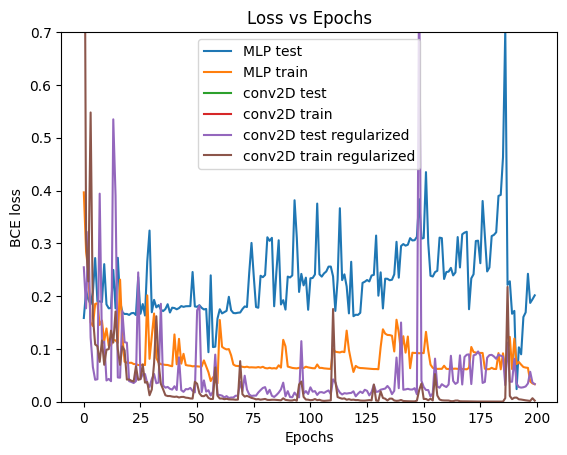

In [79]:
plt.plot(loss_stats['test'],label='MLP test')
plt.plot(loss_stats['train'],label='MLP train')
plt.plot(loss_stats_test['test'],label='conv2D test')
plt.plot(loss_stats_test['train'],label='conv2D train')
plt.plot(loss_stats_test3['test'],label='conv2D test regularized')
plt.plot(loss_stats_test3['train'],label='conv2D train regularized')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')
plt.ylim(0,0.7)
#1e-4 is not stable 
#0.1 looks clearly different 

In [80]:
c2_test=pred_torch(model3,test_im_loader)
c2_train=pred_torch(model3,train_im_loader_pred)
conf_test_c2=conf_for_torch(c2_test,target_test)
conf_train_c2=conf_for_torch(c2_train,target_train)
print("2 conv2D layers conv2D one other l2 regularized")
print("train")
print(conf_train_c2)
print("test")
print(conf_test_c2)

2 conv2D layers conv2D one other l2 regularized
train
[[1114    1]
 [   1 2167]]
test
[[483   1]
 [  4 920]]


In [81]:
#0.1 train .96728 , test  0.96814 some variation with ransom ness
# 1 has train 0.9599 , test 0.9579
#0.3 train 0.96572, test 0.96758
#0.03 train  0.97216  test  0.9702
#0.01 train 0.97635  test 0.97491
#0.003 train  0.9764 test  0.97584
#0.001 train 0.97744 test 0.97744
#0.0001 train 0.98336 test 0.96651
print("F1-scores")
print(f"Logistic train {np.round(f1_score(target_train,l_train_pred),5)}")
print(f"Logistic test {np.round(f1_score(target_test,l_test_pred),5)}")
print(f"xgboost train {np.round(f1_score(target_train,train_pred),5)}")
print(f"xgboost test {np.round(f1_score(target_test,test_pred),5)}")
print(f"perceptron train {np.round(f1_score(target_train,np.round(m_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(m_test)),5)}")
print(f"conv2d train {np.round(f1_score(target_train,np.round(c_train)),5)}")
print(f"conv2d test {np.round(f1_score(target_test,np.round(c_test)),5)}")
print(f"conv2d  regularized train {np.round(f1_score(target_train,np.round(c2_train)),5)}")
print(f"conv2d regularized test {np.round(f1_score(target_test,np.round(c2_test)),5)}")

F1-scores
Logistic train 1.0
Logistic test 0.99081
xgboost train 1.0
xgboost test 0.99351
perceptron train 0.99908
perceptron test 0.9935
conv2d train 0.79545
conv2d test 0.79245
conv2d  regularized train 0.99954
conv2d regularized test 0.99729


Now also looking on log losses.

In [82]:
#0.001 train 0.12594 test xx
#0.0001 train 0.18472 test 0.22196
print("Log lossses")
print(f"Logistic train {np.round(log_loss(target_train,l_train_pred_prob),5)}")
print(f"Logistic test {np.round(log_loss(target_test,l_test_pred_prob),5)}")
print(f"xgboost train {np.round(log_loss(target_train,train_pred_prob),5)}")
print(f"xgboost test {np.round(log_loss(target_test,test_pred_prob),5)}")
print(f"perceptron  train {np.round(log_loss(target_train,(m_train)),5)}")
print(f"perceptron test {np.round(log_loss(target_test,(m_test)),5)}")
print(f"conv2d  train {np.round(log_loss(target_train,(c_train)),5)}")
print(f"conv2d test {np.round(log_loss(target_test,(c_test)),5)}")
print(f"conv2d  regularized train {np.round(log_loss(target_train,(c2_train)),5)}")
print(f"conv2d regularized test {np.round(log_loss(target_test,(c2_test)),5)}")

Log lossses
Logistic train 0.0
Logistic test 0.39888
xgboost train 0.00124
xgboost test 0.03244
perceptron  train 0.01268
perceptron test 0.10597
conv2d  train 11.73062
conv2d test 11.87298
conv2d  regularized train 0.00158
conv2d regularized test 0.03342


For l2 of 0.1, looks now slightly better, similar in test and train from the f1 score. Still can be chance. And not better than perceptron. Regularization of 1 is too much, is less good f1 score then. ). For 0.3 is better in test but still worse than without regularization. Exploring now several options, there seems to be a best option  at some regularziation even although randomness also influences the results. 

Now I define a function to execute several l2 regularization of the same model after each other

In [83]:
#loop on regularization 
#model used, train set, test set, train set for predict, train_target, test_target
#epochs, batch?size, alpha of fit, list of regularization, optional number of features needed for perceptron 
def run_loop_torch(model,train,test,train_for_pred,train_target,test_target,epochs,batch,alpha,regs,num_features=0):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"running reg of {regs[i]}")
        keep_prob=1
        if num_features==0:
            model3 =model()
        else:
            #num_features partlz needed
            model3 =model(num_features)            
        model3.to(device)
        loss_stats_test3 = {
        'train': [], 'test': []
        }
        torch_fit(model3,train,test,epochs,batch,alpha,loss_stats_test3,l2reg=regs[i])
        test_pred=pred_torch(model3,test)
        train_pred=pred_torch(model3,train_for_pred)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(train_target,np.round(train_pred))
        stats[2,i]=f1_score(test_target,np.round(test_pred))
        stats[3,i]=log_loss(train_target,(train_pred))
        stats[4,i]=log_loss(test_target,(test_pred))   
        print(f"stats of l2reg of  {regs[i]} are {np.round(stats[1:5,i],5)}")
    print(f"full stats are {np.round(stats[:,:].T,5)}")
    return stats

 I run it for several regularization. I choose 200 epochs that convergence is possible when no overfitting occurs. With overfitting is will still change but since the aim here is to find the regularization which has not that problem, it is not a problem. 

In [ ]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1]
conv2d_stats=run_loop_torch(CNNBinary3,train_im_loader,test_im_loader,train_im_loader_pred,target_train,target_test,200,64,0.001,regs)
np.savetxt("conv2d_b_reg1_200.txt",conv2d_stats)
#loading past run with more iterations
con2d_stats=np.loadtxt("conv2d_b_reg1_200.txt")

running reg of 0.0001
Begin training.


/tmp/ipykernel_14890/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 22.43744 | Test Loss: 1.14814
Epoch 002: | Train Loss: 0.39315 | Test Loss: 0.46146
Epoch 003: | Train Loss: 0.27479 | Test Loss: 0.25506
Epoch 004: | Train Loss: 0.21094 | Test Loss: 0.37309
Epoch 005: | Train Loss: 0.81831 | Test Loss: 0.05030
Epoch 006: | Train Loss: 0.13613 | Test Loss: 0.30631
Epoch 007: | Train Loss: 0.13688 | Test Loss: 0.05716
Epoch 008: | Train Loss: 0.13541 | Test Loss: 0.04302
Epoch 009: | Train Loss: 0.13191 | Test Loss: 0.24202
Epoch 010: | Train Loss: 0.24675 | Test Loss: 0.03661
Epoch 011: | Train Loss: 0.07892 | Test Loss: 0.03332
Epoch 012: | Train Loss: 0.07967 | Test Loss: 0.03124
Epoch 013: | Train Loss: 0.01374 | Test Loss: 0.02962
Epoch 014: | Train Loss: 0.01278 | Test Loss: 0.02707
Epoch 015: | Train Loss: 0.01148 | Test Loss: 0.02604
Epoch 016: | Train Loss: 0.01293 | Test Loss: 0.02226
Epoch 017: | Train Loss: 0.01230 | Test Loss: 0.02066
Epoch 018: | Train Loss: 0.01020 | Test Loss: 0.02210
Epoch 019: | Train Loss: 0.

Epoch 153: | Train Loss: 0.00061 | Test Loss: 0.03117
Epoch 154: | Train Loss: 0.00287 | Test Loss: 0.01867
Epoch 155: | Train Loss: 0.00148 | Test Loss: 0.02220
Epoch 156: | Train Loss: 0.00973 | Test Loss: 0.02689
Epoch 157: | Train Loss: 0.00182 | Test Loss: 0.03440
Epoch 158: | Train Loss: 0.00124 | Test Loss: 0.02775
Epoch 159: | Train Loss: 0.01403 | Test Loss: 0.02248
Epoch 160: | Train Loss: 0.00623 | Test Loss: 0.02993
Epoch 161: | Train Loss: 0.00373 | Test Loss: 0.01807
Epoch 162: | Train Loss: 0.00271 | Test Loss: 0.02272
Epoch 163: | Train Loss: 0.00178 | Test Loss: 0.02098
Epoch 164: | Train Loss: 0.00079 | Test Loss: 0.03331
Epoch 165: | Train Loss: 0.03163 | Test Loss: 0.01439
Epoch 166: | Train Loss: 0.00110 | Test Loss: 0.02850
Epoch 167: | Train Loss: 0.00080 | Test Loss: 0.02423
Epoch 168: | Train Loss: 0.00963 | Test Loss: 0.10124
Epoch 169: | Train Loss: 0.08384 | Test Loss: 0.03267
Epoch 170: | Train Loss: 0.00879 | Test Loss: 0.02391
Epoch 171: | Train Loss: 0.0

/tmp/ipykernel_14890/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 3.00456 | Test Loss: 0.54063
Epoch 002: | Train Loss: 0.35194 | Test Loss: 0.10713
Epoch 003: | Train Loss: 0.14946 | Test Loss: 0.10400
Epoch 004: | Train Loss: 0.10890 | Test Loss: 0.02538
Epoch 005: | Train Loss: 0.14449 | Test Loss: 0.16750
Epoch 006: | Train Loss: 0.37409 | Test Loss: 0.04832
Epoch 007: | Train Loss: 0.14544 | Test Loss: 0.02542
Epoch 008: | Train Loss: 0.24393 | Test Loss: 0.09929
Epoch 009: | Train Loss: 0.07556 | Test Loss: 0.09229
Epoch 010: | Train Loss: 0.07399 | Test Loss: 0.09256
Epoch 011: | Train Loss: 0.01864 | Test Loss: 0.08985
Epoch 012: | Train Loss: 0.05075 | Test Loss: 0.42387
Epoch 013: | Train Loss: 0.10627 | Test Loss: 0.03642
Epoch 014: | Train Loss: 0.04326 | Test Loss: 0.25541
Epoch 015: | Train Loss: 0.07547 | Test Loss: 0.09296
Epoch 016: | Train Loss: 0.07360 | Test Loss: 0.03664
Epoch 017: | Train Loss: 0.06740 | Test Loss: 0.88338
Epoch 018: | Train Loss: 0.14458 | Test Loss: 0.02132
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.00210 | Test Loss: 0.01617
Epoch 154: | Train Loss: 0.03553 | Test Loss: 0.01800
Epoch 155: | Train Loss: 0.00491 | Test Loss: 0.02223
Epoch 156: | Train Loss: 0.00373 | Test Loss: 0.01592
Epoch 157: | Train Loss: 0.00320 | Test Loss: 0.03182
Epoch 158: | Train Loss: 0.00255 | Test Loss: 0.01541
Epoch 159: | Train Loss: 0.00218 | Test Loss: 0.01818
Epoch 160: | Train Loss: 0.00178 | Test Loss: 0.01864
Epoch 161: | Train Loss: 0.00147 | Test Loss: 0.02354
Epoch 162: | Train Loss: 0.00133 | Test Loss: 0.02103
Epoch 163: | Train Loss: 0.00104 | Test Loss: 0.02612
Epoch 164: | Train Loss: 0.00110 | Test Loss: 0.02216
Epoch 165: | Train Loss: 0.00102 | Test Loss: 0.02416
Epoch 166: | Train Loss: 0.00107 | Test Loss: 0.02512
Epoch 167: | Train Loss: 0.00084 | Test Loss: 0.02540
Epoch 168: | Train Loss: 0.00074 | Test Loss: 0.04136
Epoch 169: | Train Loss: 0.00236 | Test Loss: 0.08112
Epoch 170: | Train Loss: 0.00176 | Test Loss: 0.02847
Epoch 171: | Train Loss: 0.0

/tmp/ipykernel_14890/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 7.29705 | Test Loss: 0.32665
Epoch 002: | Train Loss: 0.32298 | Test Loss: 0.18690
Epoch 003: | Train Loss: 0.50124 | Test Loss: 0.03676
Epoch 004: | Train Loss: 0.14619 | Test Loss: 0.03639
Epoch 005: | Train Loss: 0.05092 | Test Loss: 0.03345
Epoch 006: | Train Loss: 0.02188 | Test Loss: 0.03245
Epoch 007: | Train Loss: 0.04670 | Test Loss: 0.03551
Epoch 008: | Train Loss: 0.28109 | Test Loss: 0.10534
Epoch 009: | Train Loss: 0.05269 | Test Loss: 0.11225
Epoch 010: | Train Loss: 0.10287 | Test Loss: 0.04128
Epoch 011: | Train Loss: 0.04844 | Test Loss: 0.09879
Epoch 012: | Train Loss: 0.04836 | Test Loss: 0.03803
Epoch 013: | Train Loss: 0.04706 | Test Loss: 0.03899
Epoch 014: | Train Loss: 0.11287 | Test Loss: 0.04017
Epoch 015: | Train Loss: 0.04946 | Test Loss: 0.03668
Epoch 016: | Train Loss: 0.01634 | Test Loss: 0.03606
Epoch 017: | Train Loss: 0.01506 | Test Loss: 0.03385
Epoch 018: | Train Loss: 0.01362 | Test Loss: 0.03199
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.00247 | Test Loss: 0.03171
Epoch 154: | Train Loss: 0.00225 | Test Loss: 0.03786
Epoch 155: | Train Loss: 0.02915 | Test Loss: 0.02623
Epoch 156: | Train Loss: 0.00556 | Test Loss: 0.02665
Epoch 157: | Train Loss: 0.02831 | Test Loss: 0.04290
Epoch 158: | Train Loss: 0.04478 | Test Loss: 0.04147
Epoch 159: | Train Loss: 0.01243 | Test Loss: 0.03137
Epoch 160: | Train Loss: 0.00948 | Test Loss: 0.02791
Epoch 161: | Train Loss: 0.00708 | Test Loss: 0.03377
Epoch 162: | Train Loss: 0.00581 | Test Loss: 0.02470
Epoch 163: | Train Loss: 0.00477 | Test Loss: 0.02542
Epoch 164: | Train Loss: 0.00356 | Test Loss: 0.02675
Epoch 165: | Train Loss: 0.00276 | Test Loss: 0.02657
Epoch 166: | Train Loss: 0.01332 | Test Loss: 0.02688
Epoch 167: | Train Loss: 0.00327 | Test Loss: 0.02591
Epoch 168: | Train Loss: 0.00238 | Test Loss: 0.02991
Epoch 169: | Train Loss: 0.00267 | Test Loss: 0.03104
Epoch 170: | Train Loss: 0.00197 | Test Loss: 0.03112
Epoch 171: | Train Loss: 0.0

/tmp/ipykernel_14890/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 20.17905 | Test Loss: 0.25419
Epoch 002: | Train Loss: 0.22441 | Test Loss: 0.03393
Epoch 003: | Train Loss: 0.15618 | Test Loss: 0.16640
Epoch 004: | Train Loss: 0.13786 | Test Loss: 0.03358
Epoch 005: | Train Loss: 0.08542 | Test Loss: 0.02915
Epoch 006: | Train Loss: 0.08433 | Test Loss: 0.03056
Epoch 007: | Train Loss: 0.10623 | Test Loss: 0.03026
Epoch 008: | Train Loss: 0.07980 | Test Loss: 0.02873
Epoch 009: | Train Loss: 0.14200 | Test Loss: 0.02883
Epoch 010: | Train Loss: 0.08184 | Test Loss: 0.03427
Epoch 011: | Train Loss: 0.14186 | Test Loss: 0.02750
Epoch 012: | Train Loss: 0.07680 | Test Loss: 0.02458
Epoch 013: | Train Loss: 0.08067 | Test Loss: 0.09189
Epoch 014: | Train Loss: 0.05164 | Test Loss: 0.04101
Epoch 015: | Train Loss: 0.39816 | Test Loss: 0.32236
Epoch 016: | Train Loss: 0.06848 | Test Loss: 0.02462
Epoch 017: | Train Loss: 0.04973 | Test Loss: 0.02145
Epoch 018: | Train Loss: 0.04904 | Test Loss: 0.02348
Epoch 019: | Train Loss: 0.

Epoch 153: | Train Loss: 0.00410 | Test Loss: 0.01092
Epoch 154: | Train Loss: 0.00567 | Test Loss: 0.01367
Epoch 155: | Train Loss: 0.00481 | Test Loss: 0.01139
Epoch 156: | Train Loss: 0.00362 | Test Loss: 0.01343
Epoch 157: | Train Loss: 0.00607 | Test Loss: 0.01629
Epoch 158: | Train Loss: 0.00985 | Test Loss: 0.01179
Epoch 159: | Train Loss: 0.01095 | Test Loss: 0.01240
Epoch 160: | Train Loss: 0.00672 | Test Loss: 0.01250
Epoch 161: | Train Loss: 0.00519 | Test Loss: 0.01271
Epoch 162: | Train Loss: 0.00444 | Test Loss: 0.02293
Epoch 163: | Train Loss: 0.00612 | Test Loss: 0.01478
Epoch 164: | Train Loss: 0.00498 | Test Loss: 0.01552
Epoch 165: | Train Loss: 0.00575 | Test Loss: 0.01299
Epoch 166: | Train Loss: 0.00395 | Test Loss: 0.01168
Epoch 167: | Train Loss: 0.00352 | Test Loss: 0.01306
Epoch 168: | Train Loss: 0.00423 | Test Loss: 0.01310
Epoch 169: | Train Loss: 0.00376 | Test Loss: 0.01410
Epoch 170: | Train Loss: 0.04036 | Test Loss: 0.01636
Epoch 171: | Train Loss: 0.1

/tmp/ipykernel_14890/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2.22835 | Test Loss: 0.48878
Epoch 002: | Train Loss: 0.69295 | Test Loss: 0.10894
Epoch 003: | Train Loss: 0.55436 | Test Loss: 0.61440
Epoch 004: | Train Loss: 0.32771 | Test Loss: 0.23437
Epoch 005: | Train Loss: 0.29002 | Test Loss: 0.30531
Epoch 006: | Train Loss: 0.29820 | Test Loss: 0.54091
Epoch 007: | Train Loss: 0.36809 | Test Loss: 0.09343
Epoch 008: | Train Loss: 0.29065 | Test Loss: 0.04284
Epoch 009: | Train Loss: 0.26605 | Test Loss: 0.23298
Epoch 010: | Train Loss: 0.25720 | Test Loss: 0.23182
Epoch 011: | Train Loss: 0.23964 | Test Loss: 0.09829
Epoch 012: | Train Loss: 0.23004 | Test Loss: 0.03042
Epoch 013: | Train Loss: 0.23440 | Test Loss: 0.02142
Epoch 014: | Train Loss: 0.30040 | Test Loss: 0.16711
Epoch 015: | Train Loss: 0.21723 | Test Loss: 0.24158
Epoch 016: | Train Loss: 0.19170 | Test Loss: 0.16262
Epoch 017: | Train Loss: 0.16259 | Test Loss: 0.05508
Epoch 018: | Train Loss: 0.14799 | Test Loss: 0.18862
Epoch 019: | Train Loss: 0.1

Epoch 153: | Train Loss: 0.01030 | Test Loss: 0.02092
Epoch 154: | Train Loss: 0.01054 | Test Loss: 0.01741
Epoch 155: | Train Loss: 0.01040 | Test Loss: 0.02210
Epoch 156: | Train Loss: 0.01103 | Test Loss: 0.16581
Epoch 157: | Train Loss: 0.05350 | Test Loss: 0.01815
Epoch 158: | Train Loss: 0.04232 | Test Loss: 0.02292
Epoch 159: | Train Loss: 0.01018 | Test Loss: 0.01503
Epoch 160: | Train Loss: 0.06555 | Test Loss: 0.16875
Epoch 161: | Train Loss: 0.01263 | Test Loss: 0.02209
Epoch 162: | Train Loss: 0.01022 | Test Loss: 0.01585
Epoch 163: | Train Loss: 0.00995 | Test Loss: 0.08870
Epoch 164: | Train Loss: 0.00933 | Test Loss: 0.01634
Epoch 165: | Train Loss: 0.01076 | Test Loss: 0.08836
Epoch 166: | Train Loss: 0.02980 | Test Loss: 0.03917
Epoch 167: | Train Loss: 0.01310 | Test Loss: 0.01596
Epoch 168: | Train Loss: 0.01100 | Test Loss: 0.03321
Epoch 169: | Train Loss: 0.16626 | Test Loss: 0.04842
Epoch 170: | Train Loss: 0.01710 | Test Loss: 0.01648
Epoch 171: | Train Loss: 0.0

/tmp/ipykernel_14890/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 33.37930 | Test Loss: 34.37501
Epoch 002: | Train Loss: 33.97420 | Test Loss: 34.37502
Epoch 003: | Train Loss: 33.91193 | Test Loss: 34.37503
Epoch 004: | Train Loss: 33.47585 | Test Loss: 34.37500
Epoch 005: | Train Loss: 33.97420 | Test Loss: 34.37500
Epoch 006: | Train Loss: 33.97420 | Test Loss: 34.37500
Epoch 007: | Train Loss: 33.93268 | Test Loss: 34.37500
Epoch 008: | Train Loss: 33.91192 | Test Loss: 34.37500
Epoch 009: | Train Loss: 33.89116 | Test Loss: 34.37500
Epoch 010: | Train Loss: 33.89116 | Test Loss: 34.37500
Epoch 011: | Train Loss: 33.93268 | Test Loss: 34.37500
Epoch 012: | Train Loss: 33.97420 | Test Loss: 34.37500
Epoch 013: | Train Loss: 33.95344 | Test Loss: 34.37500
Epoch 014: | Train Loss: 33.97420 | Test Loss: 34.37501
Epoch 015: | Train Loss: 33.99496 | Test Loss: 34.37501
Epoch 016: | Train Loss: 34.01097 | Test Loss: 34.37503
Epoch 017: | Train Loss: 21.96301 | Test Loss: 0.10491
Epoch 018: | Train Loss: 0.25160 | Test Loss: 0.3

Epoch 153: | Train Loss: 0.01583 | Test Loss: 0.02331
Epoch 154: | Train Loss: 0.01671 | Test Loss: 0.02339
Epoch 155: | Train Loss: 0.01607 | Test Loss: 0.02307
Epoch 156: | Train Loss: 0.01838 | Test Loss: 0.02454
Epoch 157: | Train Loss: 0.01591 | Test Loss: 0.02318
Epoch 158: | Train Loss: 0.01744 | Test Loss: 0.02221
Epoch 159: | Train Loss: 0.01526 | Test Loss: 0.02189
Epoch 160: | Train Loss: 0.01672 | Test Loss: 0.02226
Epoch 161: | Train Loss: 0.01583 | Test Loss: 0.02466
Epoch 162: | Train Loss: 0.03639 | Test Loss: 0.03188
Epoch 163: | Train Loss: 0.04330 | Test Loss: 0.02648
Epoch 164: | Train Loss: 0.01707 | Test Loss: 0.02227
Epoch 165: | Train Loss: 0.01404 | Test Loss: 0.02511
Epoch 166: | Train Loss: 0.01541 | Test Loss: 0.02846
Epoch 167: | Train Loss: 0.01546 | Test Loss: 0.02114
Epoch 168: | Train Loss: 0.01534 | Test Loss: 0.02105
Epoch 169: | Train Loss: 0.01565 | Test Loss: 0.02099
Epoch 170: | Train Loss: 0.01732 | Test Loss: 0.02229
Epoch 171: | Train Loss: 0.0

/tmp/ipykernel_14890/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 7.11843 | Test Loss: 0.29650
Epoch 002: | Train Loss: 0.39302 | Test Loss: 0.04302
Epoch 003: | Train Loss: 0.12787 | Test Loss: 0.06500
Epoch 004: | Train Loss: 0.04645 | Test Loss: 0.17946
Epoch 005: | Train Loss: 0.06263 | Test Loss: 0.02336
Epoch 006: | Train Loss: 0.04670 | Test Loss: 0.09454
Epoch 007: | Train Loss: 0.04759 | Test Loss: 0.02131
Epoch 008: | Train Loss: 0.07146 | Test Loss: 0.02095
Epoch 009: | Train Loss: 0.05297 | Test Loss: 0.13787
Epoch 010: | Train Loss: 0.03935 | Test Loss: 0.09576
Epoch 011: | Train Loss: 0.06012 | Test Loss: 0.03294
Epoch 012: | Train Loss: 0.05082 | Test Loss: 0.02253
Epoch 013: | Train Loss: 0.10485 | Test Loss: 0.02301
Epoch 014: | Train Loss: 0.06022 | Test Loss: 0.09973
Epoch 015: | Train Loss: 0.05685 | Test Loss: 0.09425
Epoch 016: | Train Loss: 0.05316 | Test Loss: 0.09352
Epoch 017: | Train Loss: 0.02881 | Test Loss: 0.18209
Epoch 018: | Train Loss: 0.10341 | Test Loss: 0.12297
Epoch 019: | Train Loss: 0.1

Epoch 153: | Train Loss: 0.06792 | Test Loss: 0.10047
Epoch 154: | Train Loss: 0.03086 | Test Loss: 0.10097
Epoch 155: | Train Loss: 0.03277 | Test Loss: 0.10121
Epoch 156: | Train Loss: 0.03126 | Test Loss: 0.10449
Epoch 157: | Train Loss: 0.07850 | Test Loss: 0.04414
Epoch 158: | Train Loss: 0.06163 | Test Loss: 0.10224
Epoch 159: | Train Loss: 0.03400 | Test Loss: 0.05467
Epoch 160: | Train Loss: 0.06479 | Test Loss: 0.10144
Epoch 161: | Train Loss: 0.03224 | Test Loss: 0.10110
Epoch 162: | Train Loss: 0.03921 | Test Loss: 0.10165
Epoch 163: | Train Loss: 0.03142 | Test Loss: 0.04386
Epoch 164: | Train Loss: 0.03262 | Test Loss: 0.17482
Epoch 165: | Train Loss: 0.07182 | Test Loss: 0.10541
Epoch 166: | Train Loss: 0.03378 | Test Loss: 0.04755
Epoch 167: | Train Loss: 0.07911 | Test Loss: 0.05012
Epoch 168: | Train Loss: 0.03632 | Test Loss: 0.10127
Epoch 169: | Train Loss: 0.03002 | Test Loss: 0.10783
Epoch 170: | Train Loss: 0.02925 | Test Loss: 0.11273
Epoch 171: | Train Loss: 0.0

/tmp/ipykernel_14890/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.89441 | Test Loss: 0.57364
Epoch 002: | Train Loss: 0.73977 | Test Loss: 0.18608
Epoch 003: | Train Loss: 0.42111 | Test Loss: 0.17309
Epoch 004: | Train Loss: 0.45832 | Test Loss: 0.11588
Epoch 005: | Train Loss: 0.16429 | Test Loss: 0.04924
Epoch 006: | Train Loss: 0.21428 | Test Loss: 0.18293
Epoch 007: | Train Loss: 0.20100 | Test Loss: 0.68257
Epoch 008: | Train Loss: 0.20967 | Test Loss: 0.04731
Epoch 009: | Train Loss: 0.27479 | Test Loss: 0.11149
Epoch 010: | Train Loss: 0.18063 | Test Loss: 0.11420
Epoch 011: | Train Loss: 0.16903 | Test Loss: 0.27920
Epoch 012: | Train Loss: 0.13262 | Test Loss: 0.05408
Epoch 013: | Train Loss: 0.18752 | Test Loss: 0.08214
Epoch 014: | Train Loss: 0.21562 | Test Loss: 0.05653
Epoch 015: | Train Loss: 0.20344 | Test Loss: 0.20874
Epoch 016: | Train Loss: 0.21003 | Test Loss: 0.08172
Epoch 017: | Train Loss: 0.14834 | Test Loss: 0.07504
Epoch 018: | Train Loss: 0.14136 | Test Loss: 0.16174
Epoch 019: | Train Loss: 0.2

Now running also the multi layer perceptron with diffrent regularizations.

In [69]:
regs=[0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1]
per_stats=run_loop_torch(BinaryClassification3,train_loader,test_loader,train_loader_pred,target_train,target_test,200,64,0.001,regs,num_features=121)
np.savetxt("per_reg1_b_200.txt",per_stats)
per_stats=np.loadtxt("per_reg1_b_200.txt")

running reg of 1e-05
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.33440 | Test Loss: 0.53737
Epoch 002: | Train Loss: 0.40850 | Test Loss: 0.58586
Epoch 003: | Train Loss: 0.41368 | Test Loss: 0.68334
Epoch 004: | Train Loss: 0.40574 | Test Loss: 0.45228
Epoch 005: | Train Loss: 0.31190 | Test Loss: 0.34944
Epoch 006: | Train Loss: 0.34686 | Test Loss: 0.20498
Epoch 007: | Train Loss: 0.34460 | Test Loss: 0.26197
Epoch 008: | Train Loss: 0.36230 | Test Loss: 0.15310
Epoch 009: | Train Loss: 0.32010 | Test Loss: 0.14044
Epoch 010: | Train Loss: 0.33975 | Test Loss: 0.28680
Epoch 011: | Train Loss: 0.29417 | Test Loss: 0.32295
Epoch 012: | Train Loss: 0.32200 | Test Loss: 0.27188
Epoch 013: | Train Loss: 0.26888 | Test Loss: 0.32407
Epoch 014: | Train Loss: 0.31021 | Test Loss: 0.21334
Epoch 015: | Train Loss: 0.26830 | Test Loss: 0.14701
Epoch 016: | Train Loss: 0.31016 | Test Loss: 0.28434
Epoch 017: | Train Loss: 0.38885 | Test Loss: 0.34845
Epoch 018: | Train Loss: 0.28634 | Test Loss: 0.14072
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.12336 | Test Loss: 0.26858
Epoch 154: | Train Loss: 0.13980 | Test Loss: 0.20833
Epoch 155: | Train Loss: 0.12416 | Test Loss: 0.29606
Epoch 156: | Train Loss: 0.12768 | Test Loss: 0.29657
Epoch 157: | Train Loss: 0.12673 | Test Loss: 0.23558
Epoch 158: | Train Loss: 0.11412 | Test Loss: 0.24905
Epoch 159: | Train Loss: 0.11212 | Test Loss: 0.31069
Epoch 160: | Train Loss: 0.10402 | Test Loss: 0.24921
Epoch 161: | Train Loss: 0.12468 | Test Loss: 0.40810
Epoch 162: | Train Loss: 0.15088 | Test Loss: 0.28374
Epoch 163: | Train Loss: 0.14978 | Test Loss: 0.41971
Epoch 164: | Train Loss: 0.13223 | Test Loss: 0.39983
Epoch 165: | Train Loss: 0.13528 | Test Loss: 0.36703
Epoch 166: | Train Loss: 0.14211 | Test Loss: 0.35900
Epoch 167: | Train Loss: 0.10682 | Test Loss: 0.35057
Epoch 168: | Train Loss: 0.10088 | Test Loss: 0.32114
Epoch 169: | Train Loss: 0.13868 | Test Loss: 0.31269
Epoch 170: | Train Loss: 0.11343 | Test Loss: 0.36507
Epoch 171: | Train Loss: 0.1

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.43592 | Test Loss: 0.55911
Epoch 002: | Train Loss: 0.35384 | Test Loss: 0.47178
Epoch 003: | Train Loss: 0.35996 | Test Loss: 0.39299
Epoch 004: | Train Loss: 0.36058 | Test Loss: 0.33215
Epoch 005: | Train Loss: 0.35724 | Test Loss: 0.28537
Epoch 006: | Train Loss: 0.32335 | Test Loss: 0.33252
Epoch 007: | Train Loss: 0.34932 | Test Loss: 0.32610
Epoch 008: | Train Loss: 0.34286 | Test Loss: 0.45912
Epoch 009: | Train Loss: 0.34708 | Test Loss: 0.28787
Epoch 010: | Train Loss: 0.34154 | Test Loss: 0.27112
Epoch 011: | Train Loss: 0.34682 | Test Loss: 0.33486
Epoch 012: | Train Loss: 0.34306 | Test Loss: 0.38335
Epoch 013: | Train Loss: 0.30794 | Test Loss: 0.27750
Epoch 014: | Train Loss: 0.34562 | Test Loss: 0.33982
Epoch 015: | Train Loss: 0.31583 | Test Loss: 0.20262
Epoch 016: | Train Loss: 0.30218 | Test Loss: 0.14214
Epoch 017: | Train Loss: 0.26994 | Test Loss: 0.14563
Epoch 018: | Train Loss: 0.31659 | Test Loss: 0.15415
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.16875 | Test Loss: 0.33160
Epoch 154: | Train Loss: 0.17383 | Test Loss: 0.35293
Epoch 155: | Train Loss: 0.16236 | Test Loss: 0.33964
Epoch 156: | Train Loss: 0.17098 | Test Loss: 0.28253
Epoch 157: | Train Loss: 0.16365 | Test Loss: 0.28684
Epoch 158: | Train Loss: 0.16230 | Test Loss: 0.35621
Epoch 159: | Train Loss: 0.17831 | Test Loss: 0.29864
Epoch 160: | Train Loss: 0.21759 | Test Loss: 0.40869
Epoch 161: | Train Loss: 0.19606 | Test Loss: 0.31266
Epoch 162: | Train Loss: 0.18337 | Test Loss: 0.32778
Epoch 163: | Train Loss: 0.17861 | Test Loss: 0.30415
Epoch 164: | Train Loss: 0.17834 | Test Loss: 0.32015
Epoch 165: | Train Loss: 0.18607 | Test Loss: 0.32779
Epoch 166: | Train Loss: 0.18123 | Test Loss: 0.53304
Epoch 167: | Train Loss: 0.18935 | Test Loss: 0.31077
Epoch 168: | Train Loss: 0.17647 | Test Loss: 0.35141
Epoch 169: | Train Loss: 0.17313 | Test Loss: 0.37455
Epoch 170: | Train Loss: 0.17637 | Test Loss: 0.36472
Epoch 171: | Train Loss: 0.1

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.53038 | Test Loss: 0.61192
Epoch 002: | Train Loss: 0.47041 | Test Loss: 0.53482
Epoch 003: | Train Loss: 0.38564 | Test Loss: 0.35496
Epoch 004: | Train Loss: 0.38384 | Test Loss: 0.44957
Epoch 005: | Train Loss: 0.34134 | Test Loss: 0.44513
Epoch 006: | Train Loss: 0.37085 | Test Loss: 0.15016
Epoch 007: | Train Loss: 0.31784 | Test Loss: 0.19050
Epoch 008: | Train Loss: 0.35365 | Test Loss: 0.27149
Epoch 009: | Train Loss: 0.47639 | Test Loss: 0.28141
Epoch 010: | Train Loss: 0.38278 | Test Loss: 0.45094
Epoch 011: | Train Loss: 0.29870 | Test Loss: 0.44800
Epoch 012: | Train Loss: 0.28723 | Test Loss: 0.39194
Epoch 013: | Train Loss: 0.28896 | Test Loss: 0.24284
Epoch 014: | Train Loss: 0.29670 | Test Loss: 0.32495
Epoch 015: | Train Loss: 0.29414 | Test Loss: 0.34886
Epoch 016: | Train Loss: 0.26098 | Test Loss: 0.33909
Epoch 017: | Train Loss: 0.26104 | Test Loss: 0.33997
Epoch 018: | Train Loss: 0.28919 | Test Loss: 0.27802
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.16974 | Test Loss: 0.24893
Epoch 154: | Train Loss: 0.17060 | Test Loss: 0.22972
Epoch 155: | Train Loss: 0.17236 | Test Loss: 0.29929
Epoch 156: | Train Loss: 0.16948 | Test Loss: 0.25344
Epoch 157: | Train Loss: 0.17296 | Test Loss: 0.30228
Epoch 158: | Train Loss: 0.18073 | Test Loss: 0.31744
Epoch 159: | Train Loss: 0.15794 | Test Loss: 0.23907
Epoch 160: | Train Loss: 0.16746 | Test Loss: 0.23536
Epoch 161: | Train Loss: 0.16213 | Test Loss: 0.24596
Epoch 162: | Train Loss: 0.26653 | Test Loss: 0.22880
Epoch 163: | Train Loss: 0.18111 | Test Loss: 0.24913
Epoch 164: | Train Loss: 0.17829 | Test Loss: 0.23171
Epoch 165: | Train Loss: 0.17256 | Test Loss: 0.28491
Epoch 166: | Train Loss: 0.15808 | Test Loss: 0.23083
Epoch 167: | Train Loss: 0.17085 | Test Loss: 0.23609
Epoch 168: | Train Loss: 0.15968 | Test Loss: 0.23659
Epoch 169: | Train Loss: 0.14772 | Test Loss: 0.22982
Epoch 170: | Train Loss: 0.15074 | Test Loss: 0.24206
Epoch 171: | Train Loss: 0.1

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.54201 | Test Loss: 0.30360
Epoch 002: | Train Loss: 0.47189 | Test Loss: 0.61644
Epoch 003: | Train Loss: 0.37466 | Test Loss: 0.46834
Epoch 004: | Train Loss: 0.45905 | Test Loss: 0.52735
Epoch 005: | Train Loss: 0.30766 | Test Loss: 0.54897
Epoch 006: | Train Loss: 0.34210 | Test Loss: 0.19218
Epoch 007: | Train Loss: 0.27059 | Test Loss: 0.18908
Epoch 008: | Train Loss: 0.24737 | Test Loss: 0.18667
Epoch 009: | Train Loss: 0.24602 | Test Loss: 0.31207
Epoch 010: | Train Loss: 0.26501 | Test Loss: 0.16589
Epoch 011: | Train Loss: 0.31124 | Test Loss: 0.13325
Epoch 012: | Train Loss: 0.26277 | Test Loss: 0.19405
Epoch 013: | Train Loss: 0.28730 | Test Loss: 0.13218
Epoch 014: | Train Loss: 0.31541 | Test Loss: 0.26785
Epoch 015: | Train Loss: 0.28827 | Test Loss: 0.26505
Epoch 016: | Train Loss: 0.28851 | Test Loss: 0.13880
Epoch 017: | Train Loss: 0.26024 | Test Loss: 0.14952
Epoch 018: | Train Loss: 0.25288 | Test Loss: 0.13615
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.13493 | Test Loss: 0.20166
Epoch 154: | Train Loss: 0.13228 | Test Loss: 0.25352
Epoch 155: | Train Loss: 0.12866 | Test Loss: 0.19085
Epoch 156: | Train Loss: 0.12243 | Test Loss: 0.19174
Epoch 157: | Train Loss: 0.12527 | Test Loss: 0.19555
Epoch 158: | Train Loss: 0.12666 | Test Loss: 0.25098
Epoch 159: | Train Loss: 0.13558 | Test Loss: 0.21545
Epoch 160: | Train Loss: 0.12506 | Test Loss: 0.27237
Epoch 161: | Train Loss: 0.12368 | Test Loss: 0.20847
Epoch 162: | Train Loss: 0.11699 | Test Loss: 0.20623
Epoch 163: | Train Loss: 0.12195 | Test Loss: 0.19018
Epoch 164: | Train Loss: 0.11891 | Test Loss: 0.21145
Epoch 165: | Train Loss: 0.11885 | Test Loss: 0.26495
Epoch 166: | Train Loss: 0.11565 | Test Loss: 0.25619
Epoch 167: | Train Loss: 0.11584 | Test Loss: 0.24302
Epoch 168: | Train Loss: 0.11643 | Test Loss: 0.26143
Epoch 169: | Train Loss: 0.11851 | Test Loss: 0.22526
Epoch 170: | Train Loss: 0.15229 | Test Loss: 0.21209
Epoch 171: | Train Loss: 0.1

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.43944 | Test Loss: 0.53986
Epoch 002: | Train Loss: 0.34317 | Test Loss: 0.45890
Epoch 003: | Train Loss: 0.34203 | Test Loss: 0.39531
Epoch 004: | Train Loss: 0.40381 | Test Loss: 0.48191
Epoch 005: | Train Loss: 0.35083 | Test Loss: 0.27251
Epoch 006: | Train Loss: 0.36928 | Test Loss: 0.27020
Epoch 007: | Train Loss: 0.36655 | Test Loss: 0.44508
Epoch 008: | Train Loss: 0.31059 | Test Loss: 0.38280
Epoch 009: | Train Loss: 0.29208 | Test Loss: 0.33210
Epoch 010: | Train Loss: 0.29851 | Test Loss: 0.13408
Epoch 011: | Train Loss: 0.31779 | Test Loss: 0.14020
Epoch 012: | Train Loss: 0.32632 | Test Loss: 0.12996
Epoch 013: | Train Loss: 0.25959 | Test Loss: 0.32512
Epoch 014: | Train Loss: 0.28427 | Test Loss: 0.14517
Epoch 015: | Train Loss: 0.31285 | Test Loss: 0.13564
Epoch 016: | Train Loss: 0.30031 | Test Loss: 0.21719
Epoch 017: | Train Loss: 0.29980 | Test Loss: 0.14104
Epoch 018: | Train Loss: 0.30952 | Test Loss: 0.52556
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.13738 | Test Loss: 0.25452
Epoch 154: | Train Loss: 0.15893 | Test Loss: 0.19161
Epoch 155: | Train Loss: 0.16630 | Test Loss: 0.26505
Epoch 156: | Train Loss: 0.14061 | Test Loss: 0.13945
Epoch 157: | Train Loss: 0.15523 | Test Loss: 0.23338
Epoch 158: | Train Loss: 0.16132 | Test Loss: 0.34625
Epoch 159: | Train Loss: 0.12233 | Test Loss: 0.28130
Epoch 160: | Train Loss: 0.16730 | Test Loss: 0.18839
Epoch 161: | Train Loss: 0.13224 | Test Loss: 0.20206
Epoch 162: | Train Loss: 0.15814 | Test Loss: 0.21327
Epoch 163: | Train Loss: 0.14954 | Test Loss: 0.21464
Epoch 164: | Train Loss: 0.15353 | Test Loss: 0.14349
Epoch 165: | Train Loss: 0.12951 | Test Loss: 0.21345
Epoch 166: | Train Loss: 0.15000 | Test Loss: 0.20368
Epoch 167: | Train Loss: 0.12444 | Test Loss: 0.26318
Epoch 168: | Train Loss: 0.11556 | Test Loss: 0.26312
Epoch 169: | Train Loss: 0.12109 | Test Loss: 0.32401
Epoch 170: | Train Loss: 0.12134 | Test Loss: 0.27293
Epoch 171: | Train Loss: 0.1

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.51433 | Test Loss: 0.39435
Epoch 002: | Train Loss: 0.52457 | Test Loss: 0.94161
Epoch 003: | Train Loss: 0.55078 | Test Loss: 0.39595
Epoch 004: | Train Loss: 0.44204 | Test Loss: 0.34009
Epoch 005: | Train Loss: 0.37205 | Test Loss: 0.44939
Epoch 006: | Train Loss: 0.31088 | Test Loss: 0.33030
Epoch 007: | Train Loss: 0.30508 | Test Loss: 0.20405
Epoch 008: | Train Loss: 0.33272 | Test Loss: 0.14586
Epoch 009: | Train Loss: 0.34639 | Test Loss: 0.14593
Epoch 010: | Train Loss: 0.34495 | Test Loss: 0.13547
Epoch 011: | Train Loss: 0.34073 | Test Loss: 0.15142
Epoch 012: | Train Loss: 0.29564 | Test Loss: 0.39059
Epoch 013: | Train Loss: 0.31553 | Test Loss: 0.46379
Epoch 014: | Train Loss: 0.34136 | Test Loss: 0.32877
Epoch 015: | Train Loss: 0.32134 | Test Loss: 0.32596
Epoch 016: | Train Loss: 0.30000 | Test Loss: 0.21119
Epoch 017: | Train Loss: 0.32125 | Test Loss: 0.39555
Epoch 018: | Train Loss: 0.32057 | Test Loss: 0.32927
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.24997 | Test Loss: 0.33090
Epoch 154: | Train Loss: 0.22782 | Test Loss: 0.33090
Epoch 155: | Train Loss: 0.22794 | Test Loss: 0.46078
Epoch 156: | Train Loss: 0.22310 | Test Loss: 0.34170
Epoch 157: | Train Loss: 0.23183 | Test Loss: 0.26977
Epoch 158: | Train Loss: 0.25566 | Test Loss: 0.27730
Epoch 159: | Train Loss: 0.22854 | Test Loss: 0.27059
Epoch 160: | Train Loss: 0.23003 | Test Loss: 0.28473
Epoch 161: | Train Loss: 0.22921 | Test Loss: 0.34037
Epoch 162: | Train Loss: 0.22540 | Test Loss: 0.27656
Epoch 163: | Train Loss: 0.21824 | Test Loss: 0.40125
Epoch 164: | Train Loss: 0.23062 | Test Loss: 0.29608
Epoch 165: | Train Loss: 0.25784 | Test Loss: 0.27597
Epoch 166: | Train Loss: 0.22244 | Test Loss: 0.34149
Epoch 167: | Train Loss: 0.25171 | Test Loss: 0.33206
Epoch 168: | Train Loss: 0.23144 | Test Loss: 0.26083
Epoch 169: | Train Loss: 0.22667 | Test Loss: 0.26213
Epoch 170: | Train Loss: 0.22341 | Test Loss: 0.26940
Epoch 171: | Train Loss: 0.2

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.69039 | Test Loss: 0.67512
Epoch 002: | Train Loss: 0.58332 | Test Loss: 0.40647
Epoch 003: | Train Loss: 0.44381 | Test Loss: 0.37819
Epoch 004: | Train Loss: 0.42621 | Test Loss: 0.34999
Epoch 005: | Train Loss: 0.40602 | Test Loss: 0.32614
Epoch 006: | Train Loss: 0.47206 | Test Loss: 1.27250
Epoch 007: | Train Loss: 0.47480 | Test Loss: 0.59202
Epoch 008: | Train Loss: 0.37675 | Test Loss: 0.51724
Epoch 009: | Train Loss: 0.44054 | Test Loss: 0.39200
Epoch 010: | Train Loss: 0.39361 | Test Loss: 0.58007
Epoch 011: | Train Loss: 0.34501 | Test Loss: 0.40351
Epoch 012: | Train Loss: 0.35349 | Test Loss: 0.34478
Epoch 013: | Train Loss: 0.35427 | Test Loss: 0.34036
Epoch 014: | Train Loss: 0.35430 | Test Loss: 0.47042
Epoch 015: | Train Loss: 0.35749 | Test Loss: 0.33554
Epoch 016: | Train Loss: 0.38053 | Test Loss: 0.39126
Epoch 017: | Train Loss: 0.38052 | Test Loss: 0.33777
Epoch 018: | Train Loss: 0.37767 | Test Loss: 0.53347
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.28840 | Test Loss: 0.31702
Epoch 154: | Train Loss: 0.29064 | Test Loss: 0.31842
Epoch 155: | Train Loss: 0.34311 | Test Loss: 0.38266
Epoch 156: | Train Loss: 1.13175 | Test Loss: 0.33631
Epoch 157: | Train Loss: 0.29137 | Test Loss: 0.32482
Epoch 158: | Train Loss: 0.31773 | Test Loss: 0.32251
Epoch 159: | Train Loss: 0.31255 | Test Loss: 0.33075
Epoch 160: | Train Loss: 0.34084 | Test Loss: 0.31085
Epoch 161: | Train Loss: 0.31631 | Test Loss: 0.30936
Epoch 162: | Train Loss: 0.28941 | Test Loss: 0.31561
Epoch 163: | Train Loss: 0.28466 | Test Loss: 0.31762
Epoch 164: | Train Loss: 0.29158 | Test Loss: 0.31604
Epoch 165: | Train Loss: 0.31162 | Test Loss: 0.27538
Epoch 166: | Train Loss: 0.29021 | Test Loss: 0.31842
Epoch 167: | Train Loss: 0.28870 | Test Loss: 0.31413
Epoch 168: | Train Loss: 0.26802 | Test Loss: 0.38258
Epoch 169: | Train Loss: 0.34142 | Test Loss: 0.31662
Epoch 170: | Train Loss: 0.33733 | Test Loss: 0.31359
Epoch 171: | Train Loss: 0.3

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.52918 | Test Loss: 0.48606
Epoch 002: | Train Loss: 0.38806 | Test Loss: 0.47423
Epoch 003: | Train Loss: 0.39218 | Test Loss: 0.53349
Epoch 004: | Train Loss: 0.33935 | Test Loss: 0.78325
Epoch 005: | Train Loss: 0.33892 | Test Loss: 0.32721
Epoch 006: | Train Loss: 0.36502 | Test Loss: 0.34121
Epoch 007: | Train Loss: 0.33769 | Test Loss: 0.59497
Epoch 008: | Train Loss: 0.35458 | Test Loss: 0.50782
Epoch 009: | Train Loss: 0.34524 | Test Loss: 0.33247
Epoch 010: | Train Loss: 0.32316 | Test Loss: 0.39799
Epoch 011: | Train Loss: 0.31921 | Test Loss: 0.38488
Epoch 012: | Train Loss: 0.34470 | Test Loss: 0.38418
Epoch 013: | Train Loss: 0.32992 | Test Loss: 0.46949
Epoch 014: | Train Loss: 0.35344 | Test Loss: 0.38440
Epoch 015: | Train Loss: 0.37377 | Test Loss: 0.72090
Epoch 016: | Train Loss: 0.37748 | Test Loss: 0.45168
Epoch 017: | Train Loss: 0.37545 | Test Loss: 0.45757
Epoch 018: | Train Loss: 0.37455 | Test Loss: 0.39584
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.26832 | Test Loss: 0.45214
Epoch 154: | Train Loss: 0.25935 | Test Loss: 0.37380
Epoch 155: | Train Loss: 0.27952 | Test Loss: 0.31793
Epoch 156: | Train Loss: 0.28934 | Test Loss: 0.37835
Epoch 157: | Train Loss: 0.32852 | Test Loss: 0.37930
Epoch 158: | Train Loss: 0.30893 | Test Loss: 0.38879
Epoch 159: | Train Loss: 0.28373 | Test Loss: 0.51021
Epoch 160: | Train Loss: 0.34206 | Test Loss: 0.37612
Epoch 161: | Train Loss: 0.31199 | Test Loss: 0.37968
Epoch 162: | Train Loss: 0.35182 | Test Loss: 0.53799
Epoch 163: | Train Loss: 0.34144 | Test Loss: 0.39994
Epoch 164: | Train Loss: 0.34193 | Test Loss: 0.25714
Epoch 165: | Train Loss: 0.28908 | Test Loss: 0.29271
Epoch 166: | Train Loss: 0.29188 | Test Loss: 0.31926
Epoch 167: | Train Loss: 0.32571 | Test Loss: 0.19246
Epoch 168: | Train Loss: 0.26219 | Test Loss: 0.56260
Epoch 169: | Train Loss: 0.32555 | Test Loss: 0.43746
Epoch 170: | Train Loss: 0.28388 | Test Loss: 0.19712
Epoch 171: | Train Loss: 0.2

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.64547 | Test Loss: 0.44289
Epoch 002: | Train Loss: 0.39343 | Test Loss: 0.61131
Epoch 003: | Train Loss: 0.44894 | Test Loss: 0.59041
Epoch 004: | Train Loss: 0.40289 | Test Loss: 0.52351
Epoch 005: | Train Loss: 0.42842 | Test Loss: 0.71728
Epoch 006: | Train Loss: 0.35930 | Test Loss: 0.53272
Epoch 007: | Train Loss: 0.30980 | Test Loss: 0.52017
Epoch 008: | Train Loss: 0.30795 | Test Loss: 0.46589
Epoch 009: | Train Loss: 0.32483 | Test Loss: 0.46644
Epoch 010: | Train Loss: 0.37219 | Test Loss: 0.49656
Epoch 011: | Train Loss: 0.32016 | Test Loss: 0.59581
Epoch 012: | Train Loss: 0.34249 | Test Loss: 0.59108
Epoch 013: | Train Loss: 0.35286 | Test Loss: 0.58766
Epoch 014: | Train Loss: 0.35247 | Test Loss: 0.58422
Epoch 015: | Train Loss: 0.35221 | Test Loss: 0.59183
Epoch 016: | Train Loss: 0.28325 | Test Loss: 0.46512
Epoch 017: | Train Loss: 0.33438 | Test Loss: 0.51890
Epoch 018: | Train Loss: 0.30487 | Test Loss: 0.52042
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.24707 | Test Loss: 0.45825
Epoch 154: | Train Loss: 0.28060 | Test Loss: 0.59992
Epoch 155: | Train Loss: 0.30511 | Test Loss: 0.54259
Epoch 156: | Train Loss: 0.28997 | Test Loss: 0.46381
Epoch 157: | Train Loss: 0.29215 | Test Loss: 0.52677
Epoch 158: | Train Loss: 0.34789 | Test Loss: 0.59300
Epoch 159: | Train Loss: 0.28142 | Test Loss: 0.47517
Epoch 160: | Train Loss: 0.30160 | Test Loss: 0.59737
Epoch 161: | Train Loss: 0.28186 | Test Loss: 0.59335
Epoch 162: | Train Loss: 0.28043 | Test Loss: 0.46846
Epoch 163: | Train Loss: 0.28586 | Test Loss: 0.55262
Epoch 164: | Train Loss: 0.32621 | Test Loss: 0.46504
Epoch 165: | Train Loss: 0.29186 | Test Loss: 0.46152
Epoch 166: | Train Loss: 0.28325 | Test Loss: 0.58914
Epoch 167: | Train Loss: 0.28792 | Test Loss: 0.52502
Epoch 168: | Train Loss: 0.28356 | Test Loss: 0.52500
Epoch 169: | Train Loss: 0.29729 | Test Loss: 0.49185
Epoch 170: | Train Loss: 0.30483 | Test Loss: 0.52092
Epoch 171: | Train Loss: 0.2

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.40791 | Test Loss: 0.57425
Epoch 002: | Train Loss: 0.43742 | Test Loss: 0.54739
Epoch 003: | Train Loss: 0.43148 | Test Loss: 0.58736
Epoch 004: | Train Loss: 0.36057 | Test Loss: 0.58749
Epoch 005: | Train Loss: 0.30958 | Test Loss: 0.57560
Epoch 006: | Train Loss: 0.31411 | Test Loss: 0.55861
Epoch 007: | Train Loss: 0.31701 | Test Loss: 0.50828
Epoch 008: | Train Loss: 0.34345 | Test Loss: 0.56400
Epoch 009: | Train Loss: 0.32287 | Test Loss: 0.64454
Epoch 010: | Train Loss: 0.34163 | Test Loss: 0.69788
Epoch 011: | Train Loss: 0.35316 | Test Loss: 0.61143
Epoch 012: | Train Loss: 0.33459 | Test Loss: 0.68344
Epoch 013: | Train Loss: 0.40416 | Test Loss: 0.57161
Epoch 014: | Train Loss: 0.35400 | Test Loss: 0.63978
Epoch 015: | Train Loss: 0.30602 | Test Loss: 0.61635
Epoch 016: | Train Loss: 0.31261 | Test Loss: 0.61202
Epoch 017: | Train Loss: 0.31217 | Test Loss: 0.57158
Epoch 018: | Train Loss: 0.29443 | Test Loss: 0.57041
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.32546 | Test Loss: 0.56226
Epoch 154: | Train Loss: 0.30622 | Test Loss: 0.55986
Epoch 155: | Train Loss: 0.33057 | Test Loss: 0.56039
Epoch 156: | Train Loss: 0.31405 | Test Loss: 0.67540
Epoch 157: | Train Loss: 0.32936 | Test Loss: 0.51564
Epoch 158: | Train Loss: 0.30879 | Test Loss: 0.56155
Epoch 159: | Train Loss: 0.33193 | Test Loss: 0.56506
Epoch 160: | Train Loss: 0.33219 | Test Loss: 0.60711
Epoch 161: | Train Loss: 0.30408 | Test Loss: 0.55679
Epoch 162: | Train Loss: 0.34779 | Test Loss: 0.70445
Epoch 163: | Train Loss: 0.31242 | Test Loss: 0.53057
Epoch 164: | Train Loss: 0.29876 | Test Loss: 0.68482
Epoch 165: | Train Loss: 0.29290 | Test Loss: 0.57532
Epoch 166: | Train Loss: 0.36128 | Test Loss: 0.67875
Epoch 167: | Train Loss: 0.31686 | Test Loss: 0.62507
Epoch 168: | Train Loss: 0.29911 | Test Loss: 0.63115
Epoch 169: | Train Loss: 0.30747 | Test Loss: 0.61610
Epoch 170: | Train Loss: 0.30583 | Test Loss: 0.67820
Epoch 171: | Train Loss: 0.2

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.40754 | Test Loss: 0.55991
Epoch 002: | Train Loss: 0.42273 | Test Loss: 0.66376
Epoch 003: | Train Loss: 0.35992 | Test Loss: 0.64984
Epoch 004: | Train Loss: 0.35614 | Test Loss: 0.64568
Epoch 005: | Train Loss: 0.37522 | Test Loss: 0.65450
Epoch 006: | Train Loss: 0.37630 | Test Loss: 0.62861
Epoch 007: | Train Loss: 0.36483 | Test Loss: 0.65077
Epoch 008: | Train Loss: 0.36264 | Test Loss: 0.63743
Epoch 009: | Train Loss: 0.36074 | Test Loss: 0.70805
Epoch 010: | Train Loss: 0.34940 | Test Loss: 0.64601
Epoch 011: | Train Loss: 0.37405 | Test Loss: 0.70919
Epoch 012: | Train Loss: 0.35772 | Test Loss: 0.69049
Epoch 013: | Train Loss: 0.39305 | Test Loss: 0.75698
Epoch 014: | Train Loss: 0.37448 | Test Loss: 0.60062
Epoch 015: | Train Loss: 0.36023 | Test Loss: 0.63380
Epoch 016: | Train Loss: 0.36519 | Test Loss: 0.78409
Epoch 017: | Train Loss: 0.34809 | Test Loss: 0.77438
Epoch 018: | Train Loss: 0.35983 | Test Loss: 0.63677
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.35451 | Test Loss: 0.64286
Epoch 154: | Train Loss: 0.36934 | Test Loss: 0.70403
Epoch 155: | Train Loss: 0.33505 | Test Loss: 0.64813
Epoch 156: | Train Loss: 0.34733 | Test Loss: 0.60257
Epoch 157: | Train Loss: 0.34784 | Test Loss: 0.64098
Epoch 158: | Train Loss: 0.34272 | Test Loss: 0.63991
Epoch 159: | Train Loss: 0.37964 | Test Loss: 0.70002
Epoch 160: | Train Loss: 0.34243 | Test Loss: 0.64771
Epoch 161: | Train Loss: 0.35048 | Test Loss: 0.64278
Epoch 162: | Train Loss: 0.34007 | Test Loss: 0.63878
Epoch 163: | Train Loss: 0.34452 | Test Loss: 0.63582
Epoch 164: | Train Loss: 0.34096 | Test Loss: 0.62159
Epoch 165: | Train Loss: 0.34246 | Test Loss: 0.63123
Epoch 166: | Train Loss: 0.34711 | Test Loss: 0.64372
Epoch 167: | Train Loss: 0.34416 | Test Loss: 0.70654
Epoch 168: | Train Loss: 0.35218 | Test Loss: 0.60404
Epoch 169: | Train Loss: 0.34725 | Test Loss: 0.64421
Epoch 170: | Train Loss: 0.34668 | Test Loss: 0.64523
Epoch 171: | Train Loss: 0.3

Now also adding regularization to xgboost.

In [70]:
def loop_xgboost(feature_train,target_train,feature_test,target_test,regs):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"doing l2 regularization {regs[i]}")
        xc1=XGBClassifier(max_depth=6,reg_lambda=regs[i]).fit(feature_train,target_train)
        train_pred=xc1.predict(feature_train)
        test_pred=xc1.predict(feature_test)
        train_pred_prob=xc1.predict_proba(feature_train)
        test_pred_prob=xc1.predict_proba(feature_test)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(target_train,train_pred)
        stats[2,i]=f1_score(target_test,test_pred)       
        stats[3,i]=log_loss(target_train,train_pred_prob)
        stats[4,i]=log_loss(target_test,test_pred_prob)
    return stats

In [91]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100,300,1000,3000,10000]
stats_xgb=loop_xgboost(feature_train,target_train,feature_test,target_test,regs)
print(stats_xgb.T)

doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03
doing l2 regularization 0.1
doing l2 regularization 0.3
doing l2 regularization 1
doing l2 regularization 3
doing l2 regularization 10
doing l2 regularization 30
doing l2 regularization 100
doing l2 regularization 300
doing l2 regularization 1000
doing l2 regularization 3000
doing l2 regularization 10000
[[1.00000000e-04 1.00000000e+00 9.64912281e-01 2.51956692e-03
  1.71278638e-01]
 [3.00000000e-04 1.00000000e+00 9.61658031e-01 2.30595113e-03
  1.59827181e-01]
 [1.00000000e-03 1.00000000e+00 9.62694301e-01 2.39115854e-03
  1.70769301e-01]
 [3.00000000e-03 1.00000000e+00 9.64839710e-01 2.40291345e-03
  1.70816850e-01]
 [1.00000000e-02 1.00000000e+00 9.62694301e-01 2.42729959e-03
  1.67822680e-01]
 [3.00000000e-02 1.00000000e+00 9.63383187e-01 2.40727017e-03
  1.69079506e-01]
 [1.00000000e-01 1.00000000e+00 9.

Now also adding logistic regression with l2 regularization. 

In [72]:
def loop_logistic(feature_train,target_train,feature_test,target_test,regs):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"doing l2 regularization {regs[i]}")
        xc1=LogisticRegression(max_iter=3000,penalty='l2',C=regs[i]).fit(feature_train,target_train)
        train_pred=xc1.predict(feature_train)
        test_pred=xc1.predict(feature_test)
        train_pred_prob=xc1.predict_proba(feature_train)
        test_pred_prob=xc1.predict_proba(feature_test)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(target_train,train_pred)
        stats[2,i]=f1_score(target_test,test_pred)       
        stats[3,i]=log_loss(target_train,train_pred_prob)
        stats[4,i]=log_loss(target_test,test_pred_prob)
    return stats

In [73]:
regs=[0.000001,0.000003,0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100]
stats_log=loop_logistic(feature_train,target_train,feature_test,target_test,regs)
print(np.round(stats_log.T,5))

doing l2 regularization 1e-06
doing l2 regularization 3e-06
doing l2 regularization 1e-05
doing l2 regularization 3e-05
doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03
doing l2 regularization 0.1
doing l2 regularization 0.3
doing l2 regularization 1
doing l2 regularization 3
doing l2 regularization 10
doing l2 regularization 30
doing l2 regularization 100
[[0.0000e+00 9.4492e-01 9.4675e-01 2.5416e-01 3.2373e-01]
 [0.0000e+00 9.5641e-01 9.5181e-01 2.3113e-01 3.1541e-01]
 [1.0000e-05 9.6327e-01 9.5783e-01 2.1639e-01 3.1006e-01]
 [3.0000e-05 9.6771e-01 9.6465e-01 2.0597e-01 2.8816e-01]
 [1.0000e-04 9.6941e-01 9.6311e-01 1.9275e-01 2.8229e-01]
 [3.0000e-04 9.6978e-01 9.6187e-01 1.8204e-01 2.7219e-01]
 [1.0000e-03 9.6859e-01 9.6077e-01 1.7423e-01 2.9222e-01]
 [3.0000e-03 9.6853e-01 9.5927e-01 1.6910e-01 3.1541e-01]
 [1.0000e-02 9.6891e-01 9.5364e-01 1.6520e-01 

not regularized
Logistic train 0.96705
Logistic test 0.94382
xgboost train 1.0
xgboost test 0.96269
perceptron train 0.9803
perceptron test 0.97119
conv2d train 0.98497
conv2d test 0.97172
best regularized
perceptron train 0.98188
perceptron test 0.97286
conv2d train 0.99077
conv2d test 0.97541
xgboost train 1.0
xgboost test 0.96694
logistic train 0.96978
logistic test 0.96465


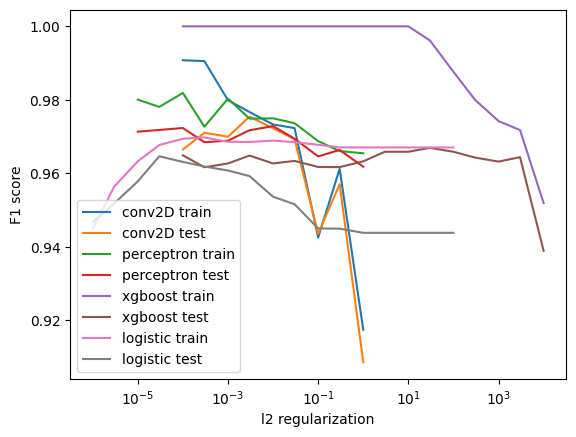

In [77]:
plt.plot(conv2d_stats[0],conv2d_stats[1],label='conv2D train')
plt.plot(conv2d_stats[0],conv2d_stats[2],label='conv2D test')
plt.plot(per_stats[0],per_stats[1],label='perceptron train')
plt.plot(per_stats[0],per_stats[2],label='perceptron test')
plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
plt.plot(stats_log[0],stats_log[1],label='logistic train')
plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
#plt.ylim(0,0.7)
plt.xscale("log")
print("not regularized")
print(f"Logistic train {np.round(f1_score(target_train,l_train_pred),5)}")
print(f"Logistic test {np.round(f1_score(target_test,l_test_pred),5)}")
print(f"xgboost train {np.round(f1_score(target_train,train_pred),5)}")
print(f"xgboost test {np.round(f1_score(target_test,test_pred),5)}")
print(f"perceptron train {np.round(f1_score(target_train,np.round(m_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(m_test)),5)}")
print(f"conv2d train {np.round(f1_score(target_train,np.round(c_train)),5)}")
print(f"conv2d test {np.round(f1_score(target_test,np.round(c_test)),5)}")
print("best regularized")
print(f"perceptron train {np.round(np.max(per_stats[1]),5)}")
print(f"perceptron test {np.round(np.max(per_stats[2]),5)}")
print(f"conv2d train {np.round(np.max(conv2d_stats[1]),5)}")
print(f"conv2d test {np.round(np.max(conv2d_stats[2]),5)}")
print(f"xgboost train {np.round(np.max(stats_xgb[1]),5)}")
print(f"xgboost test {np.round(np.max(stats_xgb[2]),5)}")
print(f"logistic train {np.round(np.max(stats_log[1]),5)}")
print(f"logistic test {np.round(np.max(stats_log[2]),5)}")

Convolutional neural network looks best in f1 score, then maybe perceptron but because this is a froad peak it could be chance. Logistic regression is better than xgbboost in f1 score. 

not regularized
Logistic train 0.1629
Logistic test 0.31918
xgboost train 0.00243
xgboost test 0.16782
perceptron train 0.10522
perceptron test 0.16862
conv2d train 0.08935
conv2d test 0.16058
best regularized
perceptron train 0.09107
perceptron test 0.16509
conv2d train 0.07705
conv2d test 0.12805
xgboost train 0.00231
xgboost test 0.12609
logistic train 0.16288
logistic test 0.27219


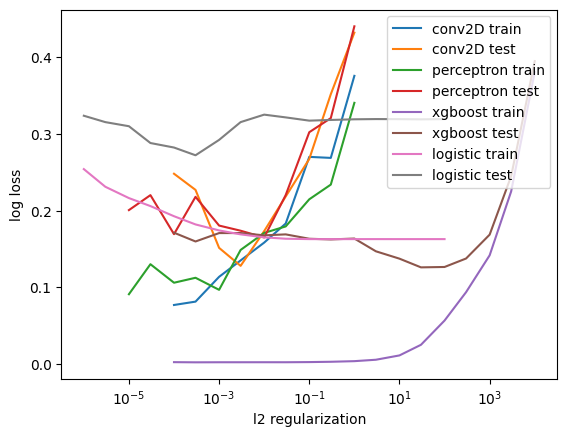

In [78]:
plt.plot(conv2d_stats[0],conv2d_stats[3],label='conv2D train')
plt.plot(conv2d_stats[0],conv2d_stats[4],label='conv2D test')
plt.plot(per_stats[0],per_stats[3],label='perceptron train')
plt.plot(per_stats[0],per_stats[4],label='perceptron test')
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
#plt.ylim(0,0.7)
plt.xscale("log")
print("not regularized")
print(f"Logistic train {np.round(log_loss(target_train,l_train_pred_prob),5)}")
print(f"Logistic test {np.round(log_loss(target_test,l_test_pred_prob),5)}")
print(f"xgboost train {np.round(log_loss(target_train,train_pred_prob),5)}")
print(f"xgboost test {np.round(log_loss(target_test,test_pred_prob),5)}")
print(f"perceptron train {np.round(log_loss(target_train,(m_train)),5)}")
print(f"perceptron test {np.round(log_loss(target_test,(m_test)),5)}")
print(f"conv2d train {np.round(log_loss(target_train,(c_train)),5)}")
print(f"conv2d test {np.round(log_loss(target_test,(c_test)),5)}")
print("best regularized")
print(f"perceptron train {np.round(np.min(per_stats[3]),5)}")
print(f"perceptron test {np.round(np.min(per_stats[4]),5)}")
print(f"conv2d train {np.round(np.min(conv2d_stats[3]),5)}")
print(f"conv2d test {np.round(np.min(conv2d_stats[4]),5)}")
print(f"xgboost train {np.round(np.min(stats_xgb[3]),5)}")
print(f"xgboost test {np.round(np.min(stats_xgb[4]),5)}")
print(f"logistic train {np.round(np.min(stats_log[3]),5)}")
print(f"logistic test {np.round(np.min(stats_log[4]),5)}")

Similar but not identical. Convolutional network is also better than perceptron, after regularization it is also better than xgboost unregularized, but the best regularization of xgboost is better. Logistic is here the worst. The best regularization depends slightkly on metric, it is 0.003 for log loss while it is 0.01 for f1 score for convolutional network in a previous run, it depends somewhat on the run. 

Next step is to run the best of all four options, possible average and look on the miss classsifed cases to see what is the reason. I decide to use log loss as to find the best one. 


First printing the value, also for checking that it is not an isolated minimum. 

In [94]:
best_reg_conv=conv2d_stats[0,(np.argmin(conv2d_stats[4]))]
print(f"best regularization of conv 2d is {best_reg_conv}")
best_reg_per=per_stats[0,(np.argmin(per_stats[4]))]
print(f"best regularization of perceptron is {best_reg_per}")
best_reg_xgb=stats_xgb[0,(np.argmin(stats_xgb[4]))]
print(f"best regularization of xgboost is {best_reg_xgb}")
best_reg_log=stats_log[0,(np.argmin(stats_log[4]))]
print(f"best regularization of logistic is {best_reg_log}")

best regularization of conv 2d is 0.003
best regularization of perceptron is 0.01
best regularization of xgboost is 30.0
best regularization of logistic is 0.0003


In [38]:
xc2=XGBClassifier(max_depth=6,reg_lambda=30.0).fit(feature_train,target_train)
x2_train_pred_prob=xc2.predict_proba(feature_train)
x2_test_pred_prob=xc2.predict_proba(feature_test)

In [39]:
lc2=LogisticRegression(penalty='l2',C=0.0003,max_iter=3000).fit(feature_train,target_train)
l2_train_pred_prob=lc2.predict_proba(feature_train)
l2_test_pred_prob=lc2.predict_proba(feature_test)

In [46]:
num_features=121
keep_prob=1
modelp =BinaryClassification3(num_features)            
modelp.to(device)
loss_stats_test3 = {
        'train': [], 'test': []
        }
torch_fit(modelp,train_loader,test_loader,200,64,0.001,loss_stats_test3,l2reg=0.01)
p2_test_pred=pred_torch(modelp,test_loader)
p2_train_pred=pred_torch(modelp,train_loader_pred)

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.04088 | Test Loss: 0.49599
Epoch 002: | Train Loss: 0.50597 | Test Loss: 0.53979
Epoch 003: | Train Loss: 0.43764 | Test Loss: 0.53153
Epoch 004: | Train Loss: 0.39680 | Test Loss: 0.53381
Epoch 005: | Train Loss: 0.39999 | Test Loss: 0.28938
Epoch 006: | Train Loss: 0.30387 | Test Loss: 0.34185
Epoch 007: | Train Loss: 0.30235 | Test Loss: 0.27242
Epoch 008: | Train Loss: 0.31966 | Test Loss: 0.26578
Epoch 009: | Train Loss: 0.32095 | Test Loss: 0.38952
Epoch 010: | Train Loss: 0.29844 | Test Loss: 0.48360
Epoch 011: | Train Loss: 0.43530 | Test Loss: 0.46372
Epoch 012: | Train Loss: 0.27722 | Test Loss: 0.51225
Epoch 013: | Train Loss: 0.29768 | Test Loss: 0.32998
Epoch 014: | Train Loss: 0.33874 | Test Loss: 0.40119
Epoch 015: | Train Loss: 0.32683 | Test Loss: 0.50694
Epoch 016: | Train Loss: 0.34178 | Test Loss: 0.15942
Epoch 017: | Train Loss: 0.31957 | Test Loss: 0.32572
Epoch 018: | Train Loss: 0.29313 | Test Loss: 0.38489
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.26034 | Test Loss: 0.26075
Epoch 154: | Train Loss: 0.23500 | Test Loss: 0.18938
Epoch 155: | Train Loss: 0.23374 | Test Loss: 0.18839
Epoch 156: | Train Loss: 0.23000 | Test Loss: 0.25649
Epoch 157: | Train Loss: 0.25587 | Test Loss: 0.32149
Epoch 158: | Train Loss: 0.28299 | Test Loss: 0.20237
Epoch 159: | Train Loss: 0.28800 | Test Loss: 0.20109
Epoch 160: | Train Loss: 0.25873 | Test Loss: 0.18836
Epoch 161: | Train Loss: 0.26270 | Test Loss: 0.18741
Epoch 162: | Train Loss: 0.28537 | Test Loss: 0.37769
Epoch 163: | Train Loss: 0.27512 | Test Loss: 0.21287
Epoch 164: | Train Loss: 0.26495 | Test Loss: 0.32374
Epoch 165: | Train Loss: 0.25447 | Test Loss: 0.18818
Epoch 166: | Train Loss: 0.23098 | Test Loss: 0.19937
Epoch 167: | Train Loss: 0.23193 | Test Loss: 0.19706
Epoch 168: | Train Loss: 0.23105 | Test Loss: 0.38261
Epoch 169: | Train Loss: 0.25857 | Test Loss: 0.37692
Epoch 170: | Train Loss: 0.25464 | Test Loss: 0.37894
Epoch 171: | Train Loss: 0.2

In [47]:
#slower than perceptron but not much 
keep_prob=1
modelc =CNNBinary3()            
modelc.to(device)
loss_stats_test_c = {
        'train': [], 'test': []
        }
torch_fit(modelc,train_im_loader,test_im_loader,200,64,0.001,loss_stats_test_c,l2reg=0.003)
c2_test_pred=pred_torch(modelc,test_im_loader)
c2_train_pred=pred_torch(modelc,train_im_loader_pred)

Begin training.


/tmp/ipykernel_2776/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 12.76737 | Test Loss: 0.70719
Epoch 002: | Train Loss: 0.75091 | Test Loss: 0.67656
Epoch 003: | Train Loss: 0.54253 | Test Loss: 1.10639
Epoch 004: | Train Loss: 0.56587 | Test Loss: 0.47097
Epoch 005: | Train Loss: 0.41924 | Test Loss: 0.45655
Epoch 006: | Train Loss: 0.43257 | Test Loss: 0.45340
Epoch 007: | Train Loss: 0.42267 | Test Loss: 0.53626
Epoch 008: | Train Loss: 0.58955 | Test Loss: 0.45419
Epoch 009: | Train Loss: 0.38110 | Test Loss: 0.44252
Epoch 010: | Train Loss: 0.40125 | Test Loss: 0.44150
Epoch 011: | Train Loss: 0.32849 | Test Loss: 0.38627
Epoch 012: | Train Loss: 0.38591 | Test Loss: 0.34586
Epoch 013: | Train Loss: 0.34754 | Test Loss: 0.45165
Epoch 014: | Train Loss: 0.30847 | Test Loss: 0.26132
Epoch 015: | Train Loss: 0.28132 | Test Loss: 0.29117
Epoch 016: | Train Loss: 0.26041 | Test Loss: 0.32077
Epoch 017: | Train Loss: 0.46137 | Test Loss: 3.53859
Epoch 018: | Train Loss: 0.30392 | Test Loss: 0.21698
Epoch 019: | Train Loss: 0.

Epoch 153: | Train Loss: 0.17986 | Test Loss: 0.29703
Epoch 154: | Train Loss: 0.21474 | Test Loss: 0.25235
Epoch 155: | Train Loss: 0.19066 | Test Loss: 0.23527
Epoch 156: | Train Loss: 0.17122 | Test Loss: 0.29989
Epoch 157: | Train Loss: 0.17572 | Test Loss: 0.25319
Epoch 158: | Train Loss: 0.20951 | Test Loss: 0.24401
Epoch 159: | Train Loss: 0.17200 | Test Loss: 0.23879
Epoch 160: | Train Loss: 0.20428 | Test Loss: 0.20052
Epoch 161: | Train Loss: 0.18968 | Test Loss: 0.23618
Epoch 162: | Train Loss: 0.19446 | Test Loss: 0.23701
Epoch 163: | Train Loss: 0.19014 | Test Loss: 0.24076
Epoch 164: | Train Loss: 0.18725 | Test Loss: 0.25144
Epoch 165: | Train Loss: 0.16741 | Test Loss: 0.23592
Epoch 166: | Train Loss: 0.18569 | Test Loss: 0.30070
Epoch 167: | Train Loss: 0.18459 | Test Loss: 0.30510
Epoch 168: | Train Loss: 0.22406 | Test Loss: 0.24113
Epoch 169: | Train Loss: 0.17294 | Test Loss: 0.24038
Epoch 170: | Train Loss: 0.18402 | Test Loss: 0.39712
Epoch 171: | Train Loss: 0.1

Looking on wrong classifications concentrating on the ones which are clealy wrong. 

In [76]:
#per 50 
#conv 55
#xgb 64
c=0
for i in range(len(x2_test_pred_prob)):
    avg=(x2_test_pred_prob[i,1]+c2_test_pred[i]+p2_test_pred[i])/3
    p=np.array([x2_test_pred_prob[i,1],p2_test_pred[i],c2_test_pred[i]])
    if abs(avg-target_test[i])>0.9:
        print(f"case {i} galaxy is {target_test[i]} with p {np.round(p,3)}")
        c+=1
print(c)        

case 5 galaxy is True with p [0.01  0.001 0.004]
case 159 galaxy is True with p [0.006 0.045 0.013]
case 162 galaxy is False with p [0.909 0.949 0.969]
case 224 galaxy is False with p [0.99  0.89  0.946]
case 350 galaxy is True with p [0.005 0.007 0.011]
case 457 galaxy is False with p [0.891 0.919 0.975]
case 479 galaxy is True with p [0.002 0.    0.   ]
case 741 galaxy is False with p [0.994 0.938 0.96 ]
case 1075 galaxy is False with p [0.921 0.908 0.884]
case 1096 galaxy is False with p [0.939 0.988 0.995]
case 1192 galaxy is False with p [0.988 0.955 0.976]
case 1324 galaxy is False with p [0.953 0.88  0.951]
case 1515 galaxy is False with p [0.907 0.853 0.956]
case 1561 galaxy is False with p [0.984 0.997 0.998]
14


(1578, 1, 11, 11)


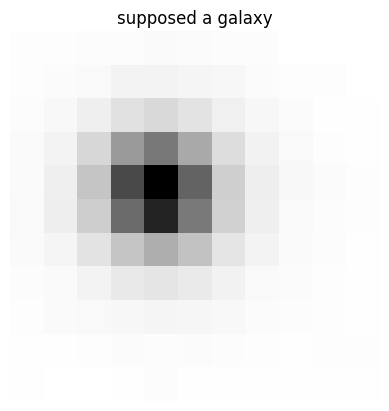

In [71]:
print(image_test.shape)
plt.axis('off')
plt.title("supposedly a galaxy")
plt.imshow(1-image_test[5,0,:,:].T,cmap=cm.gray, interpolation='nearest')

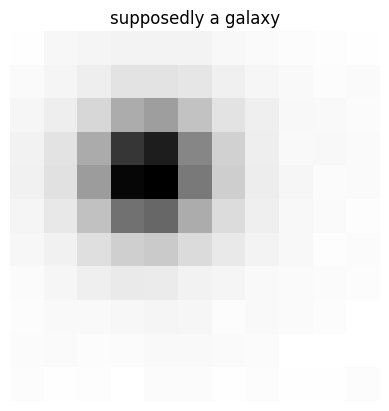

In [77]:
plt.axis('off')
plt.title("supposedly a galaxy")
plt.imshow(1-image_test[159,0,:,:].T,cmap=cm.gray, interpolation='nearest')

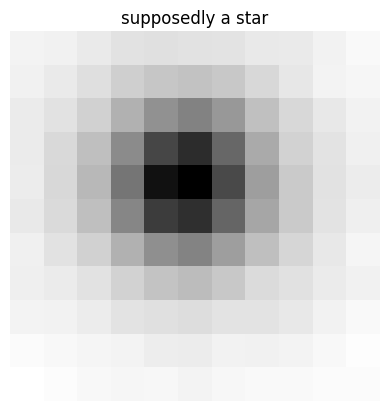

In [78]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[162,0,:,:].T,cmap=cm.gray, interpolation='nearest')

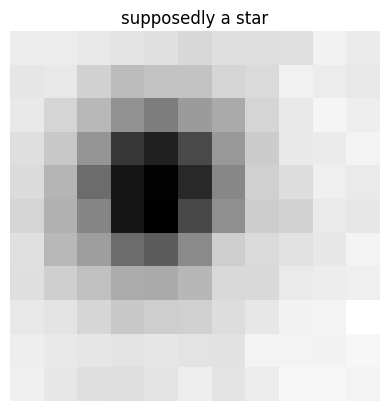

In [72]:

plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[32,0,:,:].T,cmap=cm.gray, interpolation='nearest')

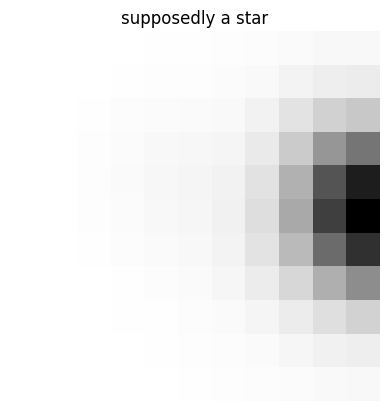

In [74]:
#is on data border makes it difficult 
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[175,0,:,:].T,cmap=cm.gray, interpolation='nearest')

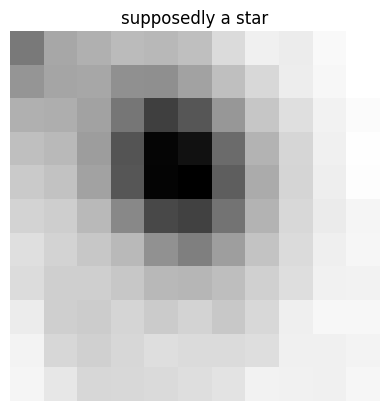

In [79]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[224,0,:,:].T,cmap=cm.gray, interpolation='nearest')

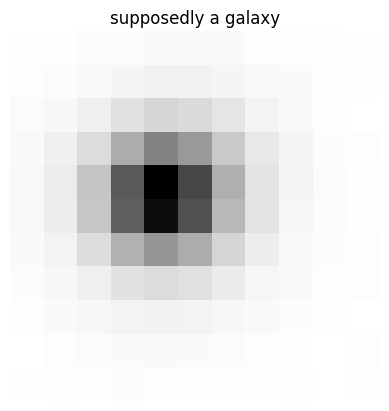

In [80]:
plt.axis('off')
plt.title("supposedly a galaxy")
plt.imshow(1-image_test[350,0,:,:].T,cmap=cm.gray, interpolation='nearest')

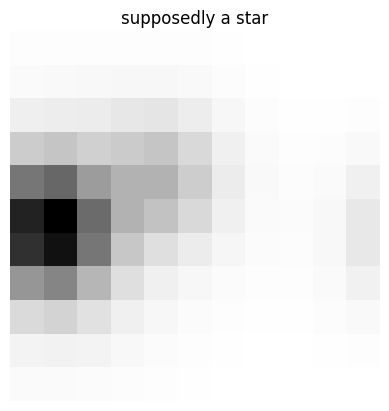

In [75]:
#several objects there, could be trhat coordinates are not exact 
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[363,0,:,:].T,cmap=cm.gray, interpolation='nearest')

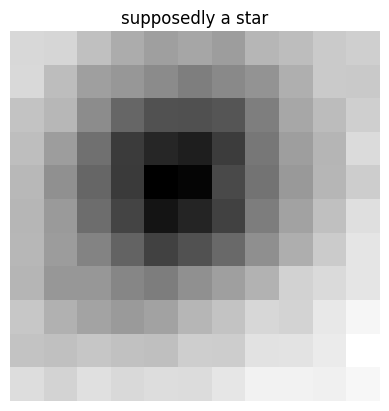

In [81]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[457,0,:,:].T,cmap=cm.gray, interpolation='nearest')

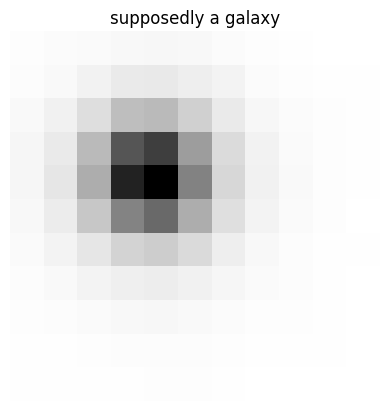

In [82]:
plt.axis('off')
plt.title("supposedly a galaxy")
plt.imshow(1-image_test[479,0,:,:].T,cmap=cm.gray, interpolation='nearest')

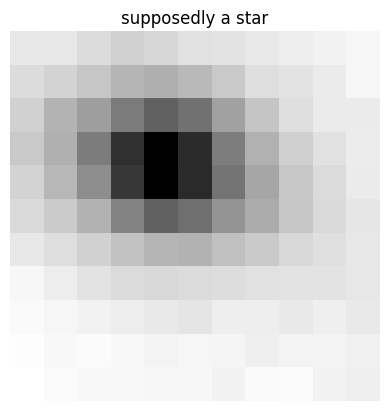

In [83]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[741,0,:,:].T,cmap=cm.gray, interpolation='nearest')

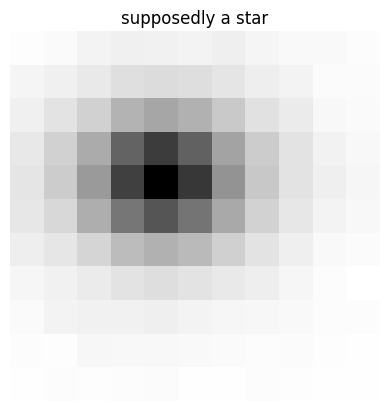

In [84]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[1075,0,:,:].T,cmap=cm.gray, interpolation='nearest')

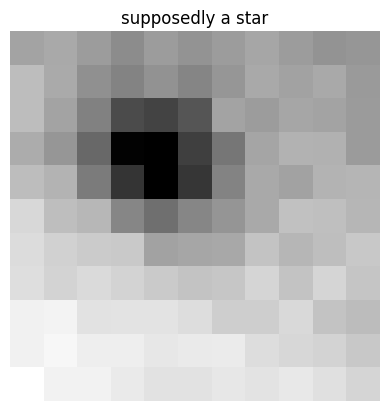

In [85]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[1096,0,:,:].T,cmap=cm.gray, interpolation='nearest')

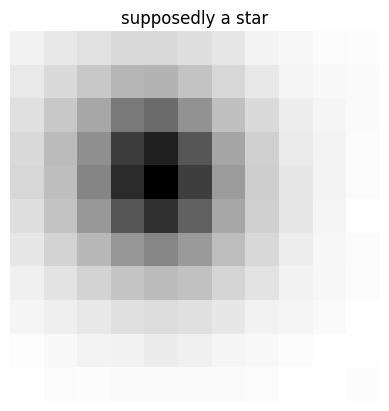

In [86]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[1192,0,:,:].T,cmap=cm.gray, interpolation='nearest')

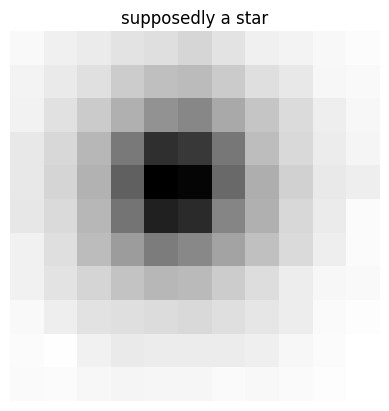

In [87]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[1324,0,:,:].T,cmap=cm.gray, interpolation='nearest')

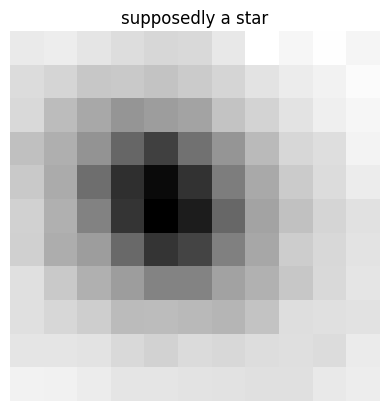

In [88]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[1515,0,:,:].T,cmap=cm.gray, interpolation='nearest')

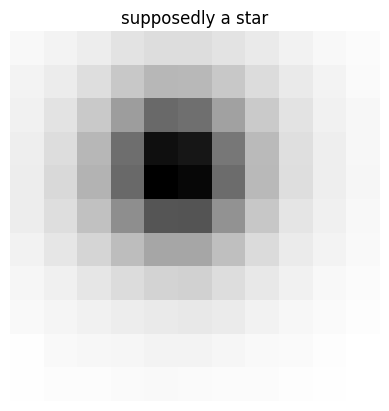

In [89]:
plt.axis('off')
plt.title("supposedly a star")
plt.imshow(1-image_test[1561,0,:,:].T,cmap=cm.gray, interpolation='nearest')

Most labelled as stars are labelled as galaxies by the algorithm, that can expected because of imblance in the sample.
All of those look rather round per eye and when there are differences it is in the level of concentration. The human eye is not particularly good in that. Thus looking on the images does not help. Algorothm are better. The labels used here come from spectra and thus are not based on the shape. In principle both test different properties and do not need to agree always. To investigate more later.  Also should get shape related parameters. 

I should also generate more data from the same images. Easy options are flipping and rotations, that add 7, thus simple size times 8. (of which half are in the other way rotating). Less clear whether adding noise works, at least needs more testing on which level is fine, it should include images which are impossible and also not too similar ones. Likely needs special splitting techniques that not too similar data is in test.  